# Предсказание покупательской активности пользователей интернет-магазина

## <u>Введение</u>

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов необходимо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

**Цель проекта**
Предсказать вероятность покупки в течение 90 дней.

**Задачи**
- Изучить данные;
- Разработать полезные признаки;
- Создать модель для классификации пользователей;
- Улучшить модель и максимизировать метрику ```roc_auc```;
- Выполнить тестирование.

**Данные**
1. ```apparel-purchases``` -- история покупок
    - `client_id` -- идентификатор пользователя
    - `quantity` -- количество товаров в заказе
    - `price` -- цена товара
    - `category_ids` -- вложенные категории, к которым отнсится товар
    - `date` -- дата покупки
    - `message_id` -- идентификатор сообщения из рассылки

2. ```apparel-messages``` -- история рекламных рассылок
    - `bulk_campaign_id` -- идентификатор рекламной кампании
    - `client_id` -- идентификатор пользователя
    - `message_id` -- идентификатор сообщений
    - `event` -- тип действия
    - `channel` -- канал рассылки
    - `date` -- дата рассылки
    - `created_at` -- точное время создания сообщения
3. ```apparel-target_binary``` -- совершит ли клиент покупку в течение следующих 90 дней
    - `client_id` -- идентификатор пользователя
    - `target` -- целевой признак

## <u>Импорт библиотек</u>

### Библиотеки

In [390]:
# импорт библиотек
import pandas as pd
import numpy as np
import re
import phik
import time
from typing import List
from ast import literal_eval
from collections import Counter

# графика
import matplotlib.pyplot as plt
import seaborn as sns


# модели
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# выборки
from sklearn.model_selection import train_test_split

# предобработка
from sklearn.preprocessing import (StandardScaler, 
                                   MinMaxScaler, 
                                   RobustScaler)

from sklearn.impute import SimpleImputer

# пайплайны
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# метрика
from sklearn.metrics import (accuracy_score, 
                            precision_score, 
                            recall_score, 
                            f1_score, 
                            roc_auc_score,
                            average_precision_score,
                            confusion_matrix,
                            precision_recall_curve,
                            make_scorer, 
                            fbeta_score)

# подбор гиперпараметров RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# анализ временных рядов
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
import numpy as np

# для оценки важности признаков
import shap

# предупреждения
import warnings

### Глобальные переменные и настройки

In [391]:
# для локального выполнения -- решение проблемы с кирилицей в путях
import tempfile
tempfile.tempdir = 'C:/temp'

In [392]:
# уберем предупреждения
warnings.filterwarnings(action="ignore")

In [393]:
# ratio тестовой выборки
TEST_SIZE = 0.25

# random seed константа -- проект начат 24.11.2025
RANDOM_STATE = 241125

In [394]:
# снимем ограничение на выводимое кол-во столбцов
pd.options.display.max_columns = None
pd.options.display.max_rows = None

## <u>Вспомогательные функции</u>

**Комментарий**: ниже представлены вспомогательные функции, которые разрабатывались и затем дорабатывались в рамках предыдущих проектов.

### Функция ```dataset_info```

In [395]:
# функция вывода общей информации о датасете
def dataset_info(data):
    """
    Функция выводит информацию о датафрейме info, describe, первые и последние 5 записей
    
    Параметры:
    ----------
        data -- датафрейм
    
    Возвращает:
    -----------
        None
    """
    print("Общая информация о датасете:")
    data.info();
    print("Описательная статистика датасета:")
    display(data.describe())
    print("Первые 5 записей:")
    display(data.head())
    print("Последние 5 записей:")
    display(data.tail())

### Функция ```plot_isna```

In [396]:
# функция для отображения количества пропусков в процентном соотношении от общего числа записей
def plot_isna(data):
    try:
        # вычисляем процент пропусков
        missing_data = data.isna().mean() * 100
        # фильтруем столбцы с пропусками и сортируем
        missing_data = missing_data[missing_data > 0].sort_values(ascending=True)
        
        if missing_data.empty:
            print('Пропуски в данных отсутствуют.')
            return
        
        # создаем горизонтальную столбчатую диаграмму
        fig, ax = plt.subplots(figsize=(13, 6))
        ax.barh(missing_data.index, missing_data, color='skyblue', edgecolor='black')
        
        # настраиваем подписи и заголовок
        ax.set_title('% пропусков в данных по столбцам\n(от общего количества записей в данных)', fontsize=14)
        ax.set_xlabel('Пропуски в данных, (%)', fontsize=12)
        ax.set_ylabel('Столбцы', fontsize=12)
        
        # настраиваем шрифт для меток на осях
        ax.tick_params(axis='both', labelsize=12)
        
        # добавляем сетку
        ax.grid(True, axis='x', linestyle='--', alpha=0.7)
        
        # строим график
        plt.show()
        print("Доля пропусков по столбцам:")
        display(missing_data)
        
    except Exception as e:
        print(f'Ошибка: {e}')

### Функция ```to_snake_case```

In [397]:
def to_snake_case(name):
    """
    Преобразует CamelCase в snake_case:
    "DateCrawled" -> "date_crawled"
    
    Параметры:
    ----------
        name -- название столбца
        
    Возвращает:
    -----------
        name -- преобразованное в snake_case из CamelCase название столбца
    """
    
    # заменяем пробелы и спецсимволы на подчеркивания
    name = re.sub(r'[\s\-()]', '_', name)
    
    # вставляем _ только между camelCase (строчная -> заглавная)
    name = re.sub(r'([a-z])([A-Z])', r'\1_\2', name)
    
    # приводим к нижнему регистру и убираем множественные подчеркивания
    name = name.lower()
    name = re.sub(r'_+', '_', name)
    
    # убираем подчеркивания в начале/конце
    return name.strip('_')

### Функция ```dataset_duplicates_info```

In [398]:
# функция для вывода общей информации о дубликатах в датафрейме
def dataset_duplicates_info(data):
    """
    Функция выводит информацию о количестве явных дубликатов в датафрейме 
    и кол-во уникальных значений в столбцах
    
    Параметры:
    ----------
        data -- датафрейм
    
    Возвращает:
    ----------- 
        None
    """
    print('Размерность данных:',data.shape)
    print(data.nunique())
    print('Количество явных дубликатов:',data.duplicated().sum())

### Функция ```get_duplicated_data```

In [399]:
# функция для вывода явных дубликатов в датафрейме по столбцу
def get_duplicated_data(data, column: str = None):
    """
    Функция возвращает данные, в которых есть явные дубликаты в столбце column
    
    Аргументы:
        data -- датафрейм
        column -- столбец, в котором ищем явные дубликаты
    
    
    Возвращает: датафрейм, который содержит записи, где в column явные дубликаты
    """
    if column is None:
        return data[data.duplicated(keep=False)]
    else:
        return data[data[column].duplicated(keep=False)]

### Функция ```remove_duplicated_data```

In [400]:
# функция для вывода явных дубликатов в датафрейме по столбцу
def remove_duplicated_data(data, column: str = None, inplace: bool = True):
    """
    Функция удаляет явные дубликаты в данных
    
    Аргументы:
        data -- датафрейм
        inplace -- флаг на удаление данных в непосредственно в исходной таблице
    
    
    Возвращает: 
        датафрейм без дубликатов если inplace=False
        None если inplace=True
    """
    print('Размерность данных до удаления дубликатов:', data.shape)
    initial_count = data.shape[0]
    
    if inplace:
        data.drop_duplicates(subset=column, inplace=True)
        removed_count = initial_count - data.shape[0]
        print(f'Удалено дубликатов: {removed_count}')
        print('Размерность данных после удаления дубликатов:', data.shape)
        return None
    else:
        result = data.drop_duplicates(subset=column)
        removed_count = initial_count - result.shape[0]
        print(f'Удалено дубликатов: {removed_count}')
        print('Размерность данных после удаления дубликатов:', result.shape)
        return result

### Функция ```plot_data_analysis```

In [401]:
# вспомогательная функция для отрисовки параметров с целью их дальнейшего анализа
# функция была написана ранее в рамках предыдущих проектов, эта версия доработанная
def plot_data_analysis(
    data,
    title: str = 'Изучение параметров',
    title_box: str = 'Диаграмма размаха',
    title_hist: str = 'Распределение',
    x_label: str = 'X',
    y_label: str = 'Y',
    plot_box: bool = True,
    plot_bar: bool = False,
    x=None,
    y=None,
    bins: int = 200,
    bar_labels=None,
    discrete=False,
    figsize=None,
    color: str = 'skyblue',
    show_stats: bool = True,
    label_angle: int = 0,
    log: bool = False
):
    """
    Функция для отрисовки данных с возможностью построения:
        boxplot (диаграмма размаха)
        гистограммы или barplot (столбчатой диаграммы)
    
    Параметры:
    ----------
        data -- данные для анализа (pd.Series, pd.DataFrame или массив)
        title -- общий заголовок
        title_box -- заголовок для boxplot
        title_hist -- заголовок для гистограммы/barplot
        x_label -- подпись оси X
        y_label -- подпись оси Y
        plot_box -- строить ли boxplot (по умолчанию True)
        plot_bar -- использовать ли barplot вместо гистограммы (по умолчанию False)
        x -- данные для оси X (если нужен barplot с внешними данными)
        y -- данные для оси Y (если нужен barplot с внешними данными)
        bins -- количество бинов для гистограммы
        bar_labels -- подписи для barplot
        discrete -- флаг для дискретных данных
        figsize -- размер графика
        color -- основной цвет графиков
        show_stats -- показывать ли статистику (по умолчанию True)
    """
    # проверка и преобразование типов ходных данных
    if not isinstance(data, (pd.Series, pd.DataFrame, np.ndarray, list)):
        raise TypeError("Данные должны быть типа pd.Series, pd.DataFrame, np.ndarray или list")
    
    if isinstance(data, (pd.DataFrame, np.ndarray, list)):
        data = pd.Series(data)
    
    # настройка размера графика
    if figsize is None:
        figsize = (13, 8) if plot_box else (13, 6)
    
    # создание subplots
    if plot_box:
        fig, (ax_box, ax_main) = plt.subplots(2, 1, figsize=figsize, 
                                             gridspec_kw={'height_ratios': [1, 2]})
        # усы
        ax_box.boxplot(data, vert=False, patch_artist=True,
                      boxprops=dict(facecolor='lightblue'))
        ax_box.set_title(title_box, pad=10)
        ax_box.set_xlabel(x_label)
        ax_box.grid(axis='x', linestyle='--', alpha=0.7)
        ax_box.set_yticks([])
    else:
        fig, ax_main = plt.subplots(1, 1, figsize=figsize)
    
    # выбор типа основного графика
    if plot_bar:
        if x is None or y is None:
            if discrete:
                value_counts = data.value_counts().sort_index()
                x = value_counts.index
                y = value_counts.values
                bar_labels = x if bar_labels is None else bar_labels
            else:
                raise ValueError("Для barplot нужно указать x и y или использовать discrete=True")
        
        ax_main.bar(x=x, height=y, color=color, edgecolor='black', alpha=0.8)
        ax_main.set_title(title_hist, pad=10)
        
        # установка подписей для дискретных данных
        if bar_labels is not None:
            ax_main.set_xticks(x if discrete else np.arange(len(x)))
            ax_main.set_xticklabels(bar_labels, rotation=label_angle, ha='right')
    else:
        # гистограмма
        ax_main.hist(data, bins=bins, color=color, edgecolor='black', alpha=0.8, log=log)
        ax_main.set_title(title_hist, pad=10)
    
    # подписи к осям и сетка
    ax_main.set_xlabel(x_label)
    ax_main.set_ylabel(y_label)
    ax_main.grid(axis='both', linestyle='--', alpha=0.5)
    
    fig.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # вывод статистики
    if show_stats:
        display(data.describe())

### Функция ```plot_funnel```

In [402]:
def plot_funnel(
    data,
    event_column: str,
    funnel_sequence: list,
    title: str = 'Маркетинговая воронка по событиям',
    color: str = 'skyblue',
    figsize: tuple = (13, 6),
    show_percentages: bool = True,
    show_values: bool = True,
    orientation: str = 'vertical'
):
    """
    Функция для построения маркетинговой воронки из столбца с событиями
    
    Параметры:
    ----------
    data : pd.DataFrame
        Датасет с данными
    event_column : str
        Столбец с событиями (click, purchase, open, etc.)
    funnel_sequence : list
        Последовательность событий в порядке воронки
    title : str
        Заголовок графика
    color : str
        Основной цвет воронки
    figsize : tuple
        Размер графика
    show_percentages : bool
        Показывать проценты конверсии
    show_values : bool
        Показывать абсолютные значения
    orientation : str
        Ориентация воронки ('vertical' или 'horizontal')
    """
    
    # проверяем, что столбец существует
    if event_column not in data.columns:
        raise ValueError(f"Столбец '{event_column}' не найден в данных!")
    
    # считаем количество каждого события
    event_counts = data[event_column].value_counts()
    
    # собираем данные по заданной последовательности
    funnel_data = []
    for event in funnel_sequence:
        if event in event_counts.index:
            funnel_data.append(event_counts[event])
        else:
            print(f"Событие '{event}' не найдено в данных!")
            funnel_data.append(0)
    
    # считаем конверсию между этапами
    conversion_rates = []
    for i in range(1, len(funnel_data)):
        if funnel_data[i-1] > 0:
            conv_rate = (funnel_data[i] / funnel_data[i-1]) * 100
        else:
            conv_rate = 0
        conversion_rates.append(conv_rate)
    
    # создаем график
    fig, ax = plt.subplots(figsize=figsize)
    
    if orientation == 'vertical':
        # вертикальная воронка
        y_pos = np.arange(len(funnel_sequence))
        bars = ax.barh(y_pos, funnel_data, color=color, alpha=0.8, edgecolor='black')
        
        # подписи
        ax.set_yticks(y_pos)
        ax.set_yticklabels(funnel_sequence)
        ax.set_xlabel('Количество событий')
        ax.set_title(title, fontsize=14, pad=20)
        
        # добавляем значения и проценты
        for i, (bar, value) in enumerate(zip(bars, funnel_data)):
            width = bar.get_width()
            
            if value > 0:
                text_parts = []
                if show_values:
                    text_parts.append(f"{value:,}")
                if show_percentages and i > 0:
                    conv_rate = conversion_rates[i-1]
                    text_parts.append(f"{conv_rate:.1f}%")
                
                # объединяем все в одну строку над баром
                label_text = "\n".join(text_parts)
                
                ax.text(width + max(funnel_data) * 0.01, 
                       bar.get_y() + bar.get_height()/2, 
                       label_text, ha='left', va='center', fontsize=9)
    
    else:
        # горизонтальная воронка
        x_pos = np.arange(len(funnel_sequence))
        bars = ax.bar(x_pos, funnel_data, color=color, alpha=0.8, edgecolor='black')
        
        # подписи
        ax.set_xticks(x_pos)
        ax.set_xticklabels(funnel_sequence, ha='right')
        ax.set_ylabel('Количество событий')
        ax.set_title(title, fontsize=14, pad=20)
        
        # добавляем значения и проценты НАД КАЖДЫМ БАРОМ
        for i, (bar, value) in enumerate(zip(bars, funnel_data)):
            height = bar.get_height()
            
            if value > 0:
                # Формируем текст для отображения над баром
                text_parts = []
                if show_values:
                    text_parts.append(f"{value:,}")
                if show_percentages and i > 0:
                    conv_rate = conversion_rates[i-1]
                    text_parts.append(f"{conv_rate:.1f}%")
                
                # Объединяем все в одну строку над баром
                label_text = "\n".join(text_parts)
                
                # Размещаем над баром
                ax.text(bar.get_x() + bar.get_width()/2, 
                       height + max(funnel_data) * 0.02, 
                       label_text, ha='center', va='bottom', fontsize=9)
    
    ax.grid(axis='y' if orientation == 'vertical' else 'x', 
           linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # выводим статистику по воронке
    print("Статистика воронки:")
    
    for i, (stage, count) in enumerate(zip(funnel_sequence, funnel_data)):
        if i == 0:
            print(f"{stage:<25} {count:>10,}: (100.0%)")
        else:
            conv_from_previous = conversion_rates[i-1] if funnel_data[i-1] > 0 else 0
            conv_from_first = (count / funnel_data[0]) * 100 if funnel_data[0] > 0 else 0
            print(f"{stage:<25} {count:>10,}: ({conv_from_previous:3.1f}% | {conv_from_first:3.1f}%)")
    
    if funnel_data[0] > 0:
        total_conversion = (funnel_data[-1] / funnel_data[0]) * 100
        print(f"Общая конверсия: {total_conversion:.2f}%")
        print(f"Потери: {funnel_data[0] - funnel_data[-1]:,} событий")
    else:
        print("Первый этап воронки имеет 0 событий!")

### Функция ```plot_decomposition_component```

In [403]:
def plot_decomposition_component(component, title, ylabel, start_date=None, end_date=None, figsize=(13, 8)):
    """
    Построение графика компонента декомпозиции
    
    Параметры:
    ----------
    component : pd.Series
        Компонент декомпозиции (trend, seasonal, residuals)
    title : str
        Заголовок графика
    ylabel : str
        Подпись оси Y
    start_date : str, optional
        Начальная дата для отображения (формат 'YYYY-MM-DD')
    end_date : str, optional  
        Конечная дата для отображения (формат 'YYYY-MM-DD')
    figsize : tuple, optional
        Размер графика
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # делаем срез по времени, если необходимо
    if start_date is not None and end_date is not None:
        data_to_plot = component.loc[start_date:end_date]
    else:
        data_to_plot = component
    
    # рисуем
    ax.plot(data_to_plot.index, data_to_plot.values)
    
    # тип компонента
    component_name = str(component.name).lower()
    if 'seasonal' in component_name:
        title += '\nСезонная компонента'
    elif 'trend' in component_name:
        title += '\nТрендовая компонента'
    elif 'residual' in component_name:
        title += '\nОстаточная компонента'
    else:
        ylabel = 'Значение'
    
    # Заголовок и подписи осей
    ax.set_title(title)
    ax.set_xlabel('Дата и время')
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    plt.show()

### Функция ```plot_corr_heatmap```

In [404]:
# функция построения тепловой карты коэффициентов корреляции Пирсона
def plot_corr_heatmap(data, 
                      title: str = 'Тепловая карта корреляции', 
                      columns: List[str] = None):
    """
    Функция для построения тепловой карты коэффициентов корреляции Пирсона
    
    Параметры:
    ----------
        data -- DataFrame
    """
    plt.figure(figsize=(24, 18))
    corr_matrix = data.phik_matrix(interval_cols=columns)
    sns.heatmap(corr_matrix, 
                annot=True,  # показывать значения в ячейках
                fmt=".2f",   # формат чисел (2 знака после запятой)
                cmap='coolwarm',  # цветовая схема
                vmin=-1, vmax=1,  # диапазон значений
                linewidths=0.5)   # ширина линий между ячейками

    # заголовок
    plt.title(title)

    # вывод графика
    plt.tight_layout()
    plt.show()
    return corr_matrix

### Функция ```plot_feature_vs_target```

In [405]:
def plot_feature_vs_target(data, 
                           feature, 
                           target,
                           x_label='Признак',
                           y_label='Количество',
                           title='Распределение признака от целевого',
                           bins=30,
                           label_angle=0,
                           scatter_alpha=0.6):
    """
    Наложенные распределения фичи по бинарному таргету со scatter plot
    
    Параметры:
    ----------
    data : DataFrame
        Датафрейм с данными
    feature : str
        Название фичи для анализа
    target : str
        Название бинарного целевого признака
    x_label: str
        Подпись оси X
    y_label: str
        Подпись оси Y
    title: str
        Заголовок графика
    bins: int
        Количество бинов для гистограммы
    label_angle: int
        Угол наклона подписей шкалы по оси X
    scatter_alpha: float
        Прозрачность точек на scatter plot
    """
    
    # cоздаем фигуру с двумя субплогами
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # разделяем данные по целевому
    data_0 = data[data[target] == 0][feature]
    data_1 = data[data[target] == 1][feature]
    
    # гистограмма/bar plot
    # непрерывных фич строим гистограммы
    if data[feature].dtype in ['int64', 'float64'] and data[feature].nunique() > 10:
        ax1.hist(data_0, alpha=0.7, label='нет риска - (0)', bins=bins, color='skyblue', edgecolor='black')
        ax1.hist(data_1, alpha=0.7, label='есть риск - (1)', bins=bins, color='salmon', edgecolor='black')
        ax1.set_ylabel(y_label)
    
    # для категориальных/дискретных - bar plot
    else:
        counts_0 = data_0.value_counts().sort_index()
        counts_1 = data_1.value_counts().sort_index()
        
        x = np.arange(len(counts_0))
        width = 0.35
        
        bars1 = ax1.bar(x - width/2, counts_0, width, label='нет риска - (0)', color='skyblue', alpha=0.8, edgecolor='black')
        bars2 = ax1.bar(x + width/2, counts_1, width, label='есть риск - (1)', color='salmon', alpha=0.8, edgecolor='black')
        
        # добавляем подписи только если не слишком много баров
        if len(counts_0) <= 20:
            ax1.bar_label(bars1, fmt='%.0f', padding=3, fontsize=8)
            ax1.bar_label(bars2, fmt='%.0f', padding=3, fontsize=8)
        
        try:
            xtick_labels = [f'{float(val):.2f}' for val in counts_0.index]
        except (ValueError, TypeError):
            xtick_labels = [str(val) for val in counts_0.index]
        ax1.set_xticks(x)
        ax1.set_xticklabels(xtick_labels, rotation=label_angle)
        ax1.set_ylabel(y_label)
    
    ax1.set_xlabel(x_label)
    ax1.set_title(f'{title}\n(Распределение)')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # scatter plot
    if data[feature].dtype in ['int64', 'float64']:
        jitter = np.random.normal(0, 0.02, size=len(data))
        y_jitter = data[target] + jitter
        
        scatter = ax2.scatter(data[feature], y_jitter, 
                             c=data[target], alpha=scatter_alpha, 
                             cmap='coolwarm', edgecolors='black', linewidth=0.5)
        
        ax2.set_xlabel(x_label)
        ax2.set_ylabel('Целевая переменная')
        ax2.set_yticks([0, 1])
        ax2.set_yticklabels(['Нет риска (0)', 'Есть риск (1)'])
        ax2.set_title(f'{title}\n(Scatter Plot)')
        ax2.grid(alpha=0.3)
        
        # фиганем линию тренда если признак числовой
        if data[feature].nunique() > 10:
            z = np.polyfit(data[feature], data[target], 1)
            p = np.poly1d(z)
            x_range = np.linspace(data[feature].min(), data[feature].max(), 100)
            ax2.plot(x_range, p(x_range), "r--", alpha=0.8, linewidth=2, 
                    label=f'Тренд (наклон: {z[0]:.3f})')
            ax2.legend()
    
    else:
        # категориальных признаков - boxplot вместо scatter
        data_boxplot = data.copy()
        data_boxplot[target] = data_boxplot[target].astype(str)
        sns.boxplot(data=data_boxplot, x=feature, y=target, ax=ax2, palette='coolwarm')
        ax2.set_title(f'{title}\n(Box Plot)')
        ax2.set_xlabel(x_label)
        ax2.set_ylabel('Целевая переменная')
    
    plt.tight_layout()
    plt.show()
    
    # статистика
    print(f"Статистика по {feature}:")
    print(f"Уникальных значений: {data[feature].nunique()}")
    print(f"Тип данных: {data[feature].dtype}")
    
    # средние значения только для числовых фич
    if data[feature].dtype in ['int64', 'float64']:
        print(f"\nСредние значения:")
        print(f"Без риска: {data_0.mean():.3f}")
        print(f"С риском: {data_1.mean():.3f}")

        # корреляция
        correlation = data[feature].corr(data[target])
        print(f"Корреляция с целевой: {correlation:.3f}")
                
        # разница средних для количественных
        if data[feature].nunique() > 10:
            mean_diff = data_1.mean() - data_0.mean()
            print(f"Разница средних (риск - нет риска): {mean_diff:.3f}")
            print(f"Относительная разница: {mean_diff/data_0.mean():.2%}")


    # доли риска для категориальных
    if data[feature].nunique() <= 10:
        risk_ratios = data.groupby(feature)[target].mean()
        print(f"\nДоли риска по категориям {feature}:")
        for category, ratio in risk_ratios.items():
            print(f"  {category}: {ratio:.1%}")

### Функция ```corr_analysis```

In [406]:
def corr_analysis(corr_matrix, 
                  target_feature, 
                  features=None, 
                  min_abs_corr=0.1):
    """
    Анализирует корреляции целевого признака с другими признаками и сортирует их по убыванию.
    
    Параметры:
    ----------
    corr_matrix : DataFrame
        Матрица корреляции (phik-матрица или обычная корреляционная матрица)
    target_feature : str
        Название целевого признака для анализа
    features : list, optional
        Список признаков для анализа (если None, берутся все из матрицы)
    min_abs_corr : float, optional
        Минимальная абсолютная корреляция для включения в результат (по умолчанию 0.1)
        
    Возвращает:
    -----------
    DataFrame
        Таблица с признаками, отсортированными по убыванию абсолютной корреляции с целевым признаком,
        с указанием силы связи по шкале Чеддока
    """
    # если не указан список признаков, берем все из матрицы (исключая целевой)
    if features is None:
        features = [col for col in corr_matrix.columns if col != target_feature]
    
    # собираем корреляции с целевым признаком
    correlations = []
    
    for feature in features:
        if feature == target_feature:
            continue
        
        corr = corr_matrix.loc[target_feature, feature]
        abs_corr = abs(corr)
        
        # реализуем шкалу Чеддока (согласно 11 спринту - 3 тема - 9 урок)
        if abs_corr >= 0.9:
            strength = 'Весьма высокая'
        elif abs_corr >= 0.7:
            strength = 'Высокая'
        elif abs_corr >= 0.5:
            strength = 'Заметная'
        elif abs_corr >= 0.3:
            strength = 'Умеренная'
        elif abs_corr >= 0.1:
            strength = 'Слабая'
        elif abs_corr > min_abs_corr and abs_corr < 0.1:
            strength = 'Очень слабая'
        elif abs_corr < min_abs_corr:
            strength = 'Отсутствует'
        
        # определяем направление связи
        direction = 'положительная' if corr > 0 else 'отрицательная'
        
        correlations.append({
            'Признак': feature,
            'Корреляция': corr,
            'Абс. корреляция': abs_corr,
            'Сила связи': strength,
            'Направление': direction
        })
    
    # создаем DataFrame и сортируем по убыванию абсолютной корреляции
    if not correlations:
        return pd.DataFrame()  # возвращаем пустой DataFrame если нет корреляций
    
    result_df = pd.DataFrame(correlations).sort_values(
        by='Абс. корреляция', ascending=False
    ).reset_index(drop=True)
    
    # вывод корреляции для удобства чтения
    result_df['Корреляция'] = result_df['Корреляция'].apply(lambda x: f"{x:.3f}")
    
    return result_df[['Признак', 'Корреляция', 'Сила связи', 'Направление']]

### Функция ```evaluate_model```

In [407]:
def evaluate_model(model, 
                   params, 
                   model_name, 
                   X_train, 
                   y_train,
                   preprocessor_ohe,
                   preprocessor_ordinal,
                   random_state=42,
                   refit_metric='roc_auc',
                   cv=3,
                   n_iter=5):
    """
    Функция для оценки моделей бинарной классификации
    
    Параметры:
    ----------
    model: модель
    params: гиперпараметры для перебора
    model_name: название модели
    X_train: входные признаки обучающей выборки
    y_train: целевой признак обучающей выборки
    preprocessor: пайплайн для предобработки
    random_state: зерно для рандома
    refit_metric: метрика для выбора лучшей модели 
                 ('roc_auc', 'recall', 'precision', 'f1', 'average_precision', 'f2')
    cv: количество cv фолдов
    n_iter: количество итераций
    
    Возвращает:
    -----------
    Словарь c параметрами:  
        - 'model_name': название модели
        - 'best_model': лучшая модель после подбора гиперпараметров
        - 'best_params': лучшие гиперпараметры
        - 'accuracy_cv': Accuracy на кросс-валидации
        - 'precision_cv': Precision на кросс-валидации
        - 'recall_cv': Recall на кросс-валидации
        - 'roc_auc_cv': ROC-AUC на кросс-валидации
        - 'average_precision_cv': Average Precision на кросс-валидации
        - 'f1_cv': F1-score на кросс-валидации
        - 'f2_cv': F2-score на кросс-валидации
        - 'params_time': время подбора гиперпараметров
        - 'train_time': среднее время обучения лучшей модели (из cv_results_df)
        - 'predict_time': среднее время предсказания лучшей модели (из cv_results_df)
        - 'cv_results_df': таблица с полной информацией из cv_results_
    """
    
    linear_models = ['LogisticRegression', 'KNeighborsClassifier']
    
    is_linear = any(linear_model in model_name for linear_model in linear_models)
    
    if 'Dummy' in model_name:
        preprocessor = preprocessor_ordinal
    elif any(linear_model in model_name for linear_model in linear_models):
        preprocessor = preprocessor_ohe
    else:
        preprocessor = preprocessor_ordinal
    
    pipeline = Pipeline(
        steps = [
            ('preprocessor', preprocessor),
            ('model', model)
        ]
    )
    
    f2_scorer = make_scorer(fbeta_score, beta=2)
    
    # метрики для классификации
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall', 
        'roc_auc': 'roc_auc',
        'f1': 'f1',
        'f2': f2_scorer,
        'average_precision': 'average_precision'
    }
    
    # Проверяем что refit_metric есть в scoring
    if refit_metric not in scoring:
        raise ValueError(f"refit_metric должен быть одним из: {list(scoring.keys())}")
    
    # замер времени подбора параметров
    search = RandomizedSearchCV(pipeline, 
                                params, 
                                n_iter=n_iter, 
                                cv=cv,
                                scoring=scoring,
                                refit=refit_metric,
                                return_train_score=True,
                                random_state=random_state,
                                n_jobs=-1)
    
    try:
        # замер времени подбора параметров
        start_time = time.time()
        search.fit(X_train, y_train)
        params_time = time.time() - start_time
    except Exception as e:
        print(f"Ошибка при подборе гиперпараметров для {model_name}: {e}")
        return None

    # берем cv_results_
    cv_results_df = pd.DataFrame(search.cv_results_)
    
    best_index = search.best_index_
    best_train_time = cv_results_df.loc[best_index, 'mean_fit_time']
    best_predict_time = cv_results_df.loc[best_index, 'mean_score_time']
    
    # берем лучшие метрики
    best_accuracy_cv = cv_results_df.loc[best_index, 'mean_test_accuracy']
    best_precision_cv = cv_results_df.loc[best_index, 'mean_test_precision']
    best_recall_cv = cv_results_df.loc[best_index, 'mean_test_recall']
    best_roc_auc_cv = cv_results_df.loc[best_index, 'mean_test_roc_auc']
    best_f1_cv = cv_results_df.loc[best_index, 'mean_test_f1']
    best_f2_cv = cv_results_df.loc[best_index, 'mean_test_f2']
    best_average_precision_cv = cv_results_df.loc[best_index, 'mean_test_average_precision']

    print(f"Модель: {model_name}")
    print(f"Лучшие параметры: {search.best_params_}")
    print(f"Время подбора параметров: {params_time:.3f} с.")
    print(f"Время обучения лучшей модели: {best_train_time:.3f} с.")
    print(f"Время предсказания лучшей модели: {best_predict_time:.3f} с.")
    print(f"Accuracy на кросс-валидации: {best_accuracy_cv:.4f}")
    print(f"Precision на кросс-валидации: {best_precision_cv:.4f}")
    print(f"Recall на кросс-валидации: {best_recall_cv:.4f}")
    print(f"ROC-AUC на кросс-валидации: {best_roc_auc_cv:.4f}")
    print(f"F1-score на кросс-валидации: {best_f1_cv:.4f}")
    print(f"F2-score на кросс-валидации: {best_f2_cv:.4f}")
    print(f"Average Precision на кросс-валидации: {best_average_precision_cv:.4f}\n")

    return {
        'model_name': model_name,
        'best_model': search.best_estimator_,
        'best_params': search.best_params_,
        'accuracy_cv': best_accuracy_cv,
        'precision_cv': best_precision_cv,
        'recall_cv': best_recall_cv,
        'roc_auc_cv': best_roc_auc_cv,
        'average_precision_cv': best_average_precision_cv,
        'f1_cv': best_f1_cv,
        'f2_cv': best_f2_cv,
        'params_time': params_time,
        'train_time': best_train_time,
        'predict_time': best_predict_time,
        'cv_results_df': cv_results_df
    }

### Функция ```plot_confusion_matrix```

In [408]:
def plot_confusion_matrix(conf_matrix, 
                          title='Матрица ошибок',
                          labels=['нет', 'да']
                         ):
    """
    Визуализирует матрицу ошибок (confusion matrix)
    
    Параметры:
    ----------
    conf_matrix : array-like
        Матрица ошибок в формате [[TN, FP], [FN, TP]]
    title : str, optional
        Заголовок графика (по умолчанию 'Матрица ошибок')
    labels : list, optional
        Подписи классов [negative, positive] (по умолчанию ['нет', 'да'])
    """
    plt.figure(figsize=(13, 6))
    ax = sns.heatmap(conf_matrix, 
                     annot=True, 
                     fmt='d', 
                     cmap='icefire',
                     xticklabels=labels,
                     yticklabels=labels)
    
    ax.set_title(title, pad=20, fontsize=12)
    ax.set_xlabel('Предсказанное значение', fontsize=10)
    ax.set_ylabel('Реальное значение', fontsize=10)
    
    # добавляем аннотации для лучшей читаемости
    for i in range(len(conf_matrix)):
        for j in range(len(conf_matrix[0])):
            text = ax.texts[i * len(conf_matrix[0]) + j]
            text.set_fontsize(12)
            text.set_fontweight('bold')
    
    plt.tight_layout()
    plt.show()

    # дополнительная текстовая интерпретация
    tn, fp, fn, tp = conf_matrix.ravel()
    print(f"Интерпретация:")
    print(f"  Правильно предсказано 'нет' (True Negative): {tn}")
    print(f"  Ложно предсказано 'да' (False Positive): {fp}")
    print(f"  Ложно предсказано 'нет' (False Negative): {fn}")
    print(f"  Правильно предсказано 'да' (True Positive): {tp}")

## <u>Загрузка данных и изучение общей информации</u>

**Комментарий**: выполним загрузку данных и изучим общую информацию о них.

### Загрузка данных

**Комментарий**: выполним загрузку данных.

In [409]:
# выполняем чтение данных
path_to_data = 'data\\'
try:
    app_purchases = pd.read_csv(f'{path_to_data}apparel-purchases.csv', parse_dates=[4])
    app_messages = pd.read_csv(f'{path_to_data}apparel-messages.csv', parse_dates=[5, 6])
    app_target = pd.read_csv(f'{path_to_data}apparel-target_binary.csv')
except:
    print("Ошибка чтения данных!")

**Промежуточный вывод**: данные успешно загружены

### Изучение общей информации

**Комментарий**: изучим общую информацию каждой таблицы.

#### Таблица ```app_purchases```

**Комментарий**: выведем общую информацию о данных ```app_purchases``` -- история покупок.

In [410]:
# выведем информацию о данных
dataset_info(app_purchases)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB
Описательная статистика датасета:


,client_id,quantity,price,date
count,2.022080e+05,202208.000000,202208.000000,202208
mean,1.515916e+18,1.006483,1193.301516,2023-03-17 02:49:35.739832064
min,1.515916e+18,1.000000,1.000000,2022-05-16 00:00:00
25%,1.515916e+18,1.000000,352.000000,2022-11-12 00:00:00
50%,1.515916e+18,1.000000,987.000000,2023-04-12 00:00:00
75%,1.515916e+18,1.000000,1699.000000,2023-07-03 00:00:00
max,1.515916e+18,30.000000,85499.000000,2024-02-16 00:00:00
std,1.459458e+08,0.184384,1342.252664,NaN


Первые 5 записей:


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


Последние 5 записей:


,client_id,quantity,price,category_ids,date,message_id
202203,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202204,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202205,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202206,1515915626010443527,1,1999.0,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490
202207,1515915626010443624,1,999.0,"['4', '28', '62', '656']",2024-02-16,1515915625488468007-14668-65cf5234b1295


**Промежуточный вывод**: с данными всё в порядке.

#### Таблица ```app_messages```

**Комментарий**: выведем общую информацию о данных ```app_messages``` -- история рекламных рассылок.

In [411]:
# выведем информацию о данных
dataset_info(app_messages)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB
Описательная статистика датасета:


,bulk_campaign_id,client_id,date,created_at
count,1.273980e+07,1.273980e+07,12739798,12739798
mean,1.160459e+04,1.515916e+18,2023-06-05 02:46:08.357990400,2023-06-05 13:58:11.168689408
min,5.480000e+02,1.515916e+18,2022-05-19 00:00:00,2022-05-19 00:14:20
25%,8.746000e+03,1.515916e+18,2022-12-19 00:00:00,2022-12-19 12:46:30
50%,1.351600e+04,1.515916e+18,2023-07-20 00:00:00,2023-07-20 17:21:54
75%,1.415800e+04,1.515916e+18,2023-11-21 00:00:00,2023-11-21 18:13:05
max,1.465700e+04,1.515916e+18,2024-02-15 00:00:00,2024-02-15 23:58:40
std,3.259211e+03,1.329704e+08,NaN,NaN


Первые 5 записей:


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


Последние 5 записей:


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
12739793,14657,1515915625477497874,1515915625477497874-14657-65cdd371cc86c,open,email,2024-02-15,2024-02-15 23:51:40
12739794,14657,1515915625765994334,1515915625765994334-14657-65cdd36018eac,open,email,2024-02-15,2024-02-15 23:52:20
12739795,14641,1515915625545014677,1515915625545014677-14641-65cb2434b25a1,open,email,2024-02-15,2024-02-15 23:52:40
12739796,14624,1515915625477497874,1515915625477497874-14624-65c5e22fb401e,open,email,2024-02-15,2024-02-15 23:58:40
12739797,14641,1515915625477497874,1515915625477497874-14641-65cb249172d68,open,email,2024-02-15,2024-02-15 23:58:40


**Промежуточный вывод**: необходимо будет проверить данные на пропуски, привести дату к корректному типу.

#### Таблица ```app_target```

**Комментарий**: выведем общую информацию о данных ```app_target``` -- целевой признак -- совершит ли клиент покупку в течение следующих 90 дней.

In [412]:
# выведем информацию о данных
dataset_info(app_target)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB
Описательная статистика датасета:


,client_id,target
count,4.984900e+04,49849.000000
mean,1.515916e+18,0.019278
std,1.487947e+08,0.137503
min,1.515916e+18,0.000000
25%,1.515916e+18,0.000000
50%,1.515916e+18,0.000000
75%,1.515916e+18,0.000000
max,1.515916e+18,1.000000


Первые 5 записей:


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


Последние 5 записей:


,client_id,target
49844,1515915626010261344,0
49845,1515915626010266132,0
49846,1515915626010439406,0
49847,1515915626010443527,0
49848,1515915626010443624,0


**Промежуточный вывод**: с данными всё в порядке.

### Промежуточный вывод

Данные успешно загружены, изучена общая информация:
- Во всех данных отсутствуют пропуски, хотя для ```app_messages``` необходимо провести дополнительную проверку из-за размера датасета.

## <u>Предобработка данных</u>

**Комментарий**: выполним предварительную обработку данных: проведем переименование столбцов, проверим данные на наличие пропусков и явных дубликатов, а также проверим корректность типов данных в столбцах таблиц.

### Пропуски в данных

**Комментарий**: проверим на пропуски данные ```app_messages``` -- данные об истории рекламных рассылок.

In [413]:
# проверим наличие пропусков
plot_isna(app_messages)

Пропуски в данных отсутствуют.


**Комментарий**: в остальных данных пропуски отсутствуют, что наблюдается при изучении общей информации о данных разделом выше.

**Промежуточный вывод**: пропуски в данных не обнаружены.

### Дубликаты в данных

**Комментарий**: проверим данные на наличие явных дубликатов.

In [414]:
# выведем информацию о явных дубликатах
dataset_duplicates_info(app_messages)

Размерность данных: (12739798, 7)
bulk_campaign_id       2709
client_id             53329
message_id          9061667
event                    11
channel                   2
date                    638
created_at          4103539
dtype: int64
Количество явных дубликатов: 48610


**Комментарий**: обнаружено **48610** явных дубликатов -- $\sim0.4\%$ от общего количества записей в данных. Предлагается их удалить, но для начала бегло просмотрим.

In [415]:
# получим явные дубликаты
duplicates = get_duplicated_data(app_messages)

In [416]:
# отсортируем дубликаты по client_id для удобства анализа
duplicates = duplicates.sort_values('client_id')

In [417]:
# выведем первые 5 явных дубликатов
duplicates.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
5109179,12566,1515915625468061003,1515915625468061003-12566-646330138e845,click,email,2023-05-16,2023-05-16 13:29:21
5109180,12566,1515915625468061003,1515915625468061003-12566-646330138e845,click,email,2023-05-16,2023-05-16 13:29:21
5656176,13332,1515915625468061100,1515915625468061100-13332-64848a3038e23,open,mobile_push,2023-06-10,2023-06-10 14:36:00
5609618,13324,1515915625468061100,1515915625468061100-13324-648403889887c,open,mobile_push,2023-06-10,2023-06-10 05:10:37
5609617,13324,1515915625468061100,1515915625468061100-13324-648403889887c,open,mobile_push,2023-06-10,2023-06-10 05:10:37


In [418]:
# выведем последние 5 явных дубликатов
duplicates.tail()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
12588291,14631,1515915626009796859,1515915626009796859-14631-65c9c261352f2,click,mobile_push,2024-02-12,2024-02-12 14:43:31
12469872,14618,1515915626009802894,1515915626009802894-14618-65c4cec6a2db8,click,mobile_push,2024-02-09,2024-02-09 05:36:42
12469871,14618,1515915626009802894,1515915626009802894-14618-65c4cec6a2db8,click,mobile_push,2024-02-09,2024-02-09 05:36:42
12738205,14653,1515915626010221592,1515915626010221592-14653-65cdc49de879f,click,mobile_push,2024-02-15,2024-02-15 09:34:58
12738204,14653,1515915626010221592,1515915626010221592-14653-65cdc49de879f,click,mobile_push,2024-02-15,2024-02-15 09:34:58


**Комментарий**: удалим явные дубликаты.

In [419]:
# удалим явные дубликаты
remove_duplicated_data(app_messages)

Размерность данных до удаления дубликатов: (12739798, 7)
Удалено дубликатов: 48610
Размерность данных после удаления дубликатов: (12691188, 7)


In [420]:
# выведем информацию о явных дубликатах
dataset_duplicates_info(app_purchases)

Размерность данных: (202208, 6)
client_id       49849
quantity           16
price            3642
category_ids      933
date              642
message_id      50204
dtype: int64
Количество явных дубликатов: 73020


**Комментарий**: обнаружено **73020** явных дубликатов -- $\sim36\%$ от общего количества записей в данных. Предлагается их удалить, но для начала бегло просмотрим.

In [421]:
# получим явные дубликаты
duplicates = get_duplicated_data(app_purchases)

In [422]:
# отсортируем дубликаты по client_id для удобства анализа
duplicates = duplicates.sort_values('client_id')

In [423]:
# выведем первые 5 явных дубликатов
duplicates.head()

,client_id,quantity,price,category_ids,date,message_id
3696,1515915625468060902,1,1999.0,"['4', '28', '260', '420']",2022-05-27,1515915625468060902-4617-6290657dac196
3698,1515915625468060902,1,1999.0,"['4', '28', '260', '420']",2022-05-27,1515915625468060902-4617-6290657dac196
3695,1515915625468060902,1,199.0,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196
3699,1515915625468060902,1,199.0,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196
81793,1515915625468061003,1,2100.0,"['4', '28', '249', '615']",2023-01-04,1515915625468061003-9148-63b54b04855a4


In [424]:
# выведем последние 5 явных дубликатов
duplicates.tail()

,client_id,quantity,price,category_ids,date,message_id
202200,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
201563,1515915626010266132,1,909.0,"['4', '27', '278', '470']",2024-02-14,1515915625999374481-14623-65c5c5acbad8c
201564,1515915626010266132,1,909.0,"['4', '27', '278', '470']",2024-02-14,1515915625999374481-14623-65c5c5acbad8c
202205,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202204,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d


**Комментарий**: удалим явные дубликаты.

In [425]:
# удалим явные дубликаты
remove_duplicated_data(app_purchases)

Размерность данных до удаления дубликатов: (202208, 6)
Удалено дубликатов: 73020
Размерность данных после удаления дубликатов: (129188, 6)


In [426]:
# выведем информацию о явных дубликатах
dataset_duplicates_info(app_target)

Размерность данных: (49849, 2)
client_id    49849
target           2
dtype: int64
Количество явных дубликатов: 0


**Промежуточный вывод**:
- В данных ```app_messages``` обнаружено и удалено **48610** явных дубликатов -- $\sim0.4\%$ от общего количества записей в данных;
- В ```app_purchases``` обнаружено и удалено **73020** явных дубликатов -- $\sim36\%$ от общего количества записей в данных.

### Промежуточный вывод

Проведена предварительная обработка данных:
- Пропуски в данных нигде не обнаружены;
- В данных ```app_messages``` и ```app_purchases``` обнаружены и удалены явные дубликаты:
    - В данных ```app_messages``` обнаружено и удалено **48610** явных дубликатов -- $\sim0.4\%$ от общего количества записей в данных;
    - В ```app_purchases``` обнаружено и удалено **73020** явных дубликатов -- $\sim36\%$ от общего количества записей в данных.

## <u>Исследовательский анализ данных</u>

**Комментарий**: проведем теперь исследовательский анализ данных.

### Таблица ```app_purchases```

**Комментарий**: исследуем таблицу ```app_purchases``` -- история покупок.

#### Признак ```client_id```

**Комментарий**: рассмотрим подробнее признак ```client_id``` -- идентификатор клиента.

In [427]:
# посмотрим количество уникальных значений
print(f'Уникальных клиентов: {app_purchases['client_id'].nunique()}')

Уникальных клиентов: 49849


**Промежуточный вывод**: в данных содержится **49849** уникальных клиентов.

#### Признак ```quantity```

**Комментарий**: рассмотрим подробнее признак ```quantity``` -- количество единиц товара.

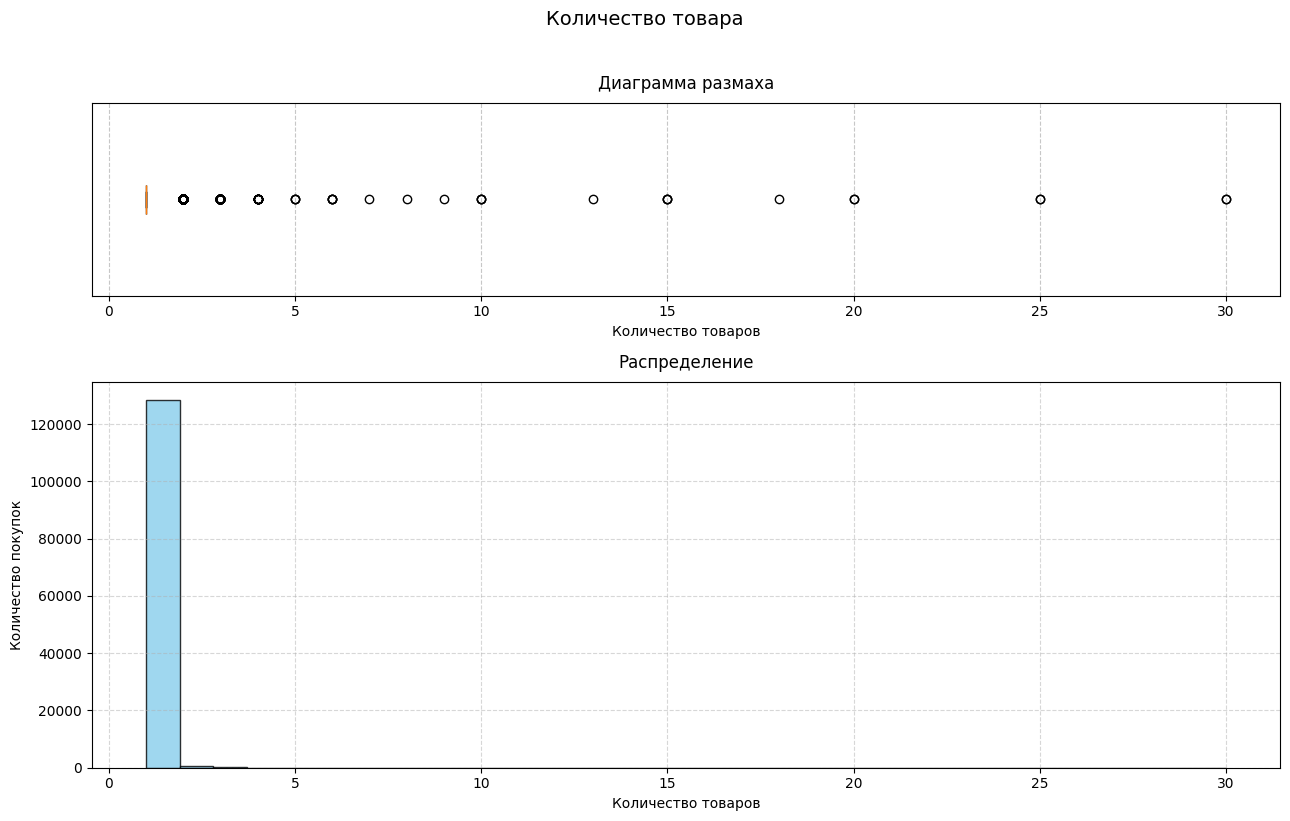

count    129188.000000
mean          1.009420
std           0.220332
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          30.000000
Name: quantity, dtype: float64

In [428]:
# выведем график распределения
plot_data_analysis(app_purchases['quantity'],
                   title = 'Количество товара',
                   x_label = 'Количество товаров',
                   y_label = 'Количество покупок',
                   plot_box = True,
                   discrete = False,
                   bins=32
                   )

**Промежуточный вывод**: подавляющее большинство товаров покупалось в количестве **1** шт.

#### Признак ```price```

**Комментарий**: рассмотрим подробнее признак ```price``` -- цена товара.

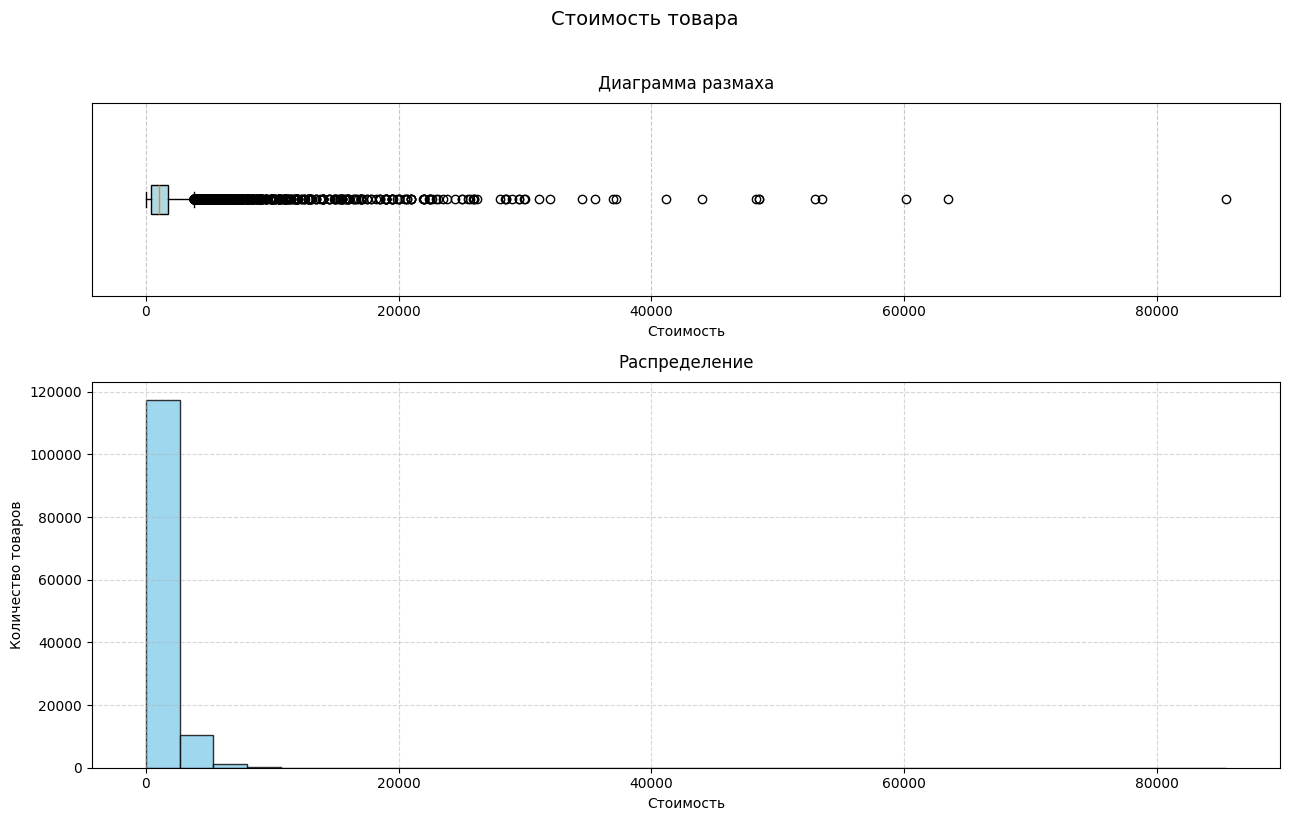

count    129188.000000
mean       1264.532766
std        1375.016339
min           1.000000
25%         399.000000
50%         999.000000
75%        1750.000000
max       85499.000000
Name: price, dtype: float64

In [429]:
# выведем график распределения
plot_data_analysis(app_purchases['price'],
                   title = 'Стоимость товара',
                   x_label = 'Стоимость',
                   y_label = 'Количество товаров',
                   plot_box = True,
                   discrete = False,
                   bins=32
                   )

**Промежуточный вывод**: в среднем стоимость товара составляет $\sim1300$, медианное значение **999**.

#### Признак ```category_ids```

**Комментарий**: рассмотрим подробнее признак ```category_ids``` -- идентификаторы категорий.

In [430]:
# посмотрим количество уникальных значений
print(f'Уникальных групп с категориями: {app_purchases['category_ids'].nunique()}')

Уникальных групп с категориями: 933


**Комментарий**: в данных группы с категориями представлены в виде строк. Предлагается следующая стратегия: выполнить парсинг строк, использовать несколько подходов для создания новых признаков:
- Найти маркеры -- категории, которые практически всегда присутствуют на верхнем уровне дерева;
- Разбить данные на категории по вложенным из ```category_ids```, убрав маркеры;
- Оставить последнюю категорию (конечную) из списка.

In [431]:
app_purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [432]:
# функция для парсинга категорий
def parse_cats(x):
    if pd.isna(x) or x is None:
        return []
    if isinstance(x, list):
        result = []
        for i in x:
            if i is not None:
                try:
                    result.append(int(i))
                except (ValueError, TypeError):
                    continue
    else:
        try:
            parsed = literal_eval(str(x))
            result = []
            for i in parsed:
                if i is not None:
                    try:
                        result.append(int(i))
                    except (ValueError, TypeError):
                        continue
        except (ValueError, SyntaxError):
            return []
    return sorted(result)

app_purchases['category_ids'] = app_purchases['category_ids'].apply(parse_cats)

# cчитаем, на каких позициях встречается каждая категория
position_counter = Counter()
for cats in app_purchases['category_ids']:
    for pos, cat in enumerate(cats):
        position_counter[(cat, pos)] += 1
        
# находим категории, которые чаще всего находятся на позиции 0
markers = []
total_counts = Counter([cat for cats in app_purchases['category_ids'] for cat in cats])

for (cat, pos), count in position_counter.items():
    if pos == 0 and count / total_counts[cat] >= 0.99:
        if cat not in markers:
            markers.append(cat)

In [433]:
# выведем маркеры
print("Обнаруженные маркеры:", sorted(markers))

Обнаруженные маркеры: [1, 2, 3, 4, 5, 447, 448, 508, 550, 551, 552, 553, 554, 555, 557, 558, 559, 560, 561, 562, 563, 564, 569, 570, 571, 572, 573, 574, 575, 576, 577, 581, 582, 589, 590, 591, 592, 593, 594, 595, 600, 601, 602, 606, 607, 608, 609, 611, 612, 614, 619, 620, 623, 624, 625, 626, 628, 631, 632, 634, 635, 636, 637, 638, 639, 640, 641, 651, 664, 665, 666, 667, 668, 669, 670, 671, 675, 676, 678, 681, 690, 691, 692, 697, 699, 700, 702, 705, 706, 707, 708, 710, 712, 713, 718, 719, 724, 725, 727, 732, 734, 735, 743, 751, 755, 761, 764, 765, 767, 769, 792, 793, 799, 806, 808, 824, 835, 836, 838, 841, 842, 843, 844, 845, 846, 848, 850, 854, 855, 856, 857, 858, 859, 878, 882, 883, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 899, 900, 901, 905, 913, 914, 915, 916, 917, 919, 923, 927, 930, 933, 935, 936, 937, 940, 941, 953, 954, 956, 957, 958, 959, 961, 963, 965, 966, 967, 968, 969, 970, 971, 972, 986, 987, 988, 991, 992, 993, 994, 995, 999, 1001, 1002, 1003, 1004, 100

In [434]:
app_purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843


In [435]:
# создаём признаки
print("Размерность исходного датасета:", app_purchases.shape)
# конечная категория
app_purchases['leaf_category'] = app_purchases['category_ids'].apply(lambda x: int(x[-1]) if len(x) > 0 else -1)
app_purchases['marker_category'] = app_purchases['category_ids'].apply(lambda x: int(x[0]) if len(x) > 0 else -1)

# маркеры
for marker in markers:
    app_purchases[f'is_marker_{marker}'] = app_purchases['category_ids'].apply(lambda x: int(marker in x[:1]))

Размерность исходного датасета: (129188, 6)


In [436]:
# выведем первые 5 записей обновленного датасета
app_purchases.drop(columns=['category_ids'], inplace=True)
print("Размерность обоновленного датасета:", app_purchases.shape)
app_purchases.head()

Размерность обоновленного датасета: (129188, 481)


,client_id,quantity,price,date,message_id,leaf_category,marker_category,is_marker_4,is_marker_2,is_marker_667,is_marker_678,is_marker_1786,is_marker_1795,is_marker_550,is_marker_710,is_marker_957,is_marker_636,is_marker_560,is_marker_608,is_marker_681,is_marker_1582,is_marker_1006,is_marker_561,is_marker_555,is_marker_572,is_marker_842,is_marker_1691,is_marker_628,is_marker_551,is_marker_676,is_marker_793,is_marker_637,is_marker_848,is_marker_577,is_marker_602,is_marker_1367,is_marker_1583,is_marker_1080,is_marker_1637,is_marker_1007,is_marker_448,is_marker_1831,is_marker_724,is_marker_1829,is_marker_727,is_marker_1687,is_marker_675,is_marker_1806,is_marker_1052,is_marker_563,is_marker_719,is_marker_601,is_marker_936,is_marker_1778,is_marker_552,is_marker_1360,is_marker_581,is_marker_930,is_marker_582,is_marker_691,is_marker_631,is_marker_564,is_marker_954,is_marker_1705,is_marker_1275,is_marker_573,is_marker_971,is_marker_1420,is_marker_913,is_marker_713,is_marker_824,is_marker_1088,is_marker_593,is_marker_1732,is_marker_1002,is_marker_1004,is_marker_592,is_marker_969,is_marker_1309,is_marker_1851,is_marker_1350,is_marker_1327,is_marker_638,is_marker_571,is_marker_1591,is_marker_594,is_marker_639,is_marker_1279,is_marker_553,is_marker_570,is_marker_508,is_marker_836,is_marker_1343,is_marker_712,is_marker_1304,is_marker_614,is_marker_835,is_marker_611,is_marker_1421,is_marker_761,is_marker_702,is_marker_700,is_marker_575,is_marker_692,is_marker_574,is_marker_1328,is_marker_705,is_marker_927,is_marker_1353,is_marker_857,is_marker_967,is_marker_966,is_marker_1342,is_marker_1326,is_marker_576,is_marker_606,is_marker_1281,is_marker_706,is_marker_755,is_marker_1426,is_marker_1010,is_marker_1773,is_marker_1352,is_marker_668,is_marker_1306,is_marker_569,is_marker_1635,is_marker_666,is_marker_557,is_marker_1685,is_marker_1659,is_marker_1094,is_marker_846,is_marker_1783,is_marker_891,is_marker_894,is_marker_1220,is_marker_634,is_marker_562,is_marker_958,is_marker_1009,is_marker_1681,is_marker_1765,is_marker_1796,is_marker_1665,is_marker_1774,is_marker_1777,is_marker_1682,is_marker_843,is_marker_1200,is_marker_665,is_marker_1418,is_marker_607,is_marker_699,is_marker_1805,is_marker_1707,is_marker_1363,is_marker_612,is_marker_1012,is_marker_664,is_marker_905,is_marker_1699,is_marker_1283,is_marker_965,is_marker_1359,is_marker_1701,is_marker_1702,is_marker_1700,is_marker_735,is_marker_670,is_marker_1399,is_marker_734,is_marker_1,is_marker_1767,is_marker_558,is_marker_844,is_marker_620,is_marker_841,is_marker_1378,is_marker_669,is_marker_1734,is_marker_1335,is_marker_1338,is_marker_1686,is_marker_1766,is_marker_1308,is_marker_1636,is_marker_1697,is_marker_1639,is_marker_1214,is_marker_1715,is_marker_1771,is_marker_1782,is_marker_1670,is_marker_1769,is_marker_1344,is_marker_1014,is_marker_732,is_marker_887,is_marker_5519,is_marker_1673,is_marker_1668,is_marker_792,is_marker_671,is_marker_941,is_marker_591,is_marker_1334,is_marker_595,is_marker_1277,is_marker_1419,is_marker_1684,is_marker_1729,is_marker_914,is_marker_915,is_marker_1588,is_marker_554,is_marker_1728,is_marker_1294,is_marker_1710,is_marker_1366,is_marker_1839,is_marker_1314,is_marker_1807,is_marker_1689,is_marker_854,is_marker_1008,is_marker_1429,is_marker_1076,is_marker_1075,is_marker_845,is_marker_1368,is_marker_1764,is_marker_1703,is_marker_1345,is_marker_1361,is_marker_1633,is_marker_1307,is_marker_1337,is_marker_1100,is_marker_1631,is_marker_1284,is_marker_1365,is_marker_1675,is_marker_1838,is_marker_1310,is_marker_883,is_marker_1850,is_marker_1688,is_marker_1128,is_marker_1104,is_marker_1005,is_marker_559,is_marker_765,is_marker_1020,is_marker_1339,is_marker_1016,is_marker_1810,is_marker_718,is_marker_1221,is_marker_1735,is_marker_632,is_marker_1678,is_marker_708,is_marker_1638,is_marker_769,is_marker_1664,is_marker_850,is_marker_1351,is_marker_1706,is_marker_1726,is_marker_1722,is_marker_1733,is_marker_1078,is_marker_1055,is_marker_1219,is_marker_1224,is_marker_1672,is_ma

**Промежуточный вывод**: были сформированые новые признаки: маркеры, конечные категории, а также данные разбиты по категориям без маркеров.

#### Признак ```message_id```

**Комментарий**: рассмотрим подробнее признак ```message_id``` -- идентификатор сообщения из рассылки.

In [437]:
# посмотрим количество уникальных значений
print(f'Уникальных сообщений: {app_purchases['message_id'].nunique()}')

Уникальных сообщений: 50204


**Промежуточный вывод**: в данных содержится **50202** уникальных разосланных сообщений.

#### Промежуточный вывод

По результатам исследоватльского анализа данных:
- В данных содержится **49849** уникальных клиентов.
- Подавляющее большинство товаров покупалось в количестве **1** шт.
- В среднем стоимость товара составляет $\sim1300$, медианное значение **999**.
- Были сформированые новые признаки: маркеры, конечные категории, а также данные разбиты по категориям без маркеров.
- В данных содержится **50202** уникальных разосланных сообщений.

### Таблица ```app_messages```

**Комментарий**: исследуем таблицу ```app_messages``` -- история рекламных рассылок.

#### Признак ```bulk_campaign_id```

**Комментарий**: рассмотрим подробнее признак ```bulk_campaign_id``` -- идентификатор рассылки.

In [438]:
# посмотрим количество уникальных значений
print(f'Уникальных рекламных компаний/рассылок: {app_messages['bulk_campaign_id'].nunique()}')

Уникальных рекламных компаний/рассылок: 2709


**Промежуточный вывод**: в данных содержится **2709** уникальных ```id``` рекламных кампаний/рассылок.

#### Признак ```client_id```

**Комментарий**: рассмотрим подробнее признак ```client_id``` -- идентификатор клиента.

In [439]:
# посмотрим количество уникальных значений
print(f'Уникальных клиентов: {app_messages['client_id'].nunique()}')

Уникальных клиентов: 53329


**Промежуточный вывод**: в данных содержится **53329** уникальных клиентов.

#### Признак ```message_id```

**Комментарий**: рассмотрим подробнее признак ```message_id``` -- идентификатор сообщения.

In [440]:
# посмотрим количество уникальных значений
print(f'Уникальных сообщений: {app_messages['message_id'].nunique()}')

Уникальных сообщений: 9061667


**Промежуточный вывод**: в данных содержится $\sim$**9** млн. уникальных разосланных сообщений.

#### Признак ```event```

**Комментарий**: рассмотрим подробнее признак ```event``` -- действие с сообщением (отправлено, открыто, покупка...).

In [441]:
# посмотрим уникальные значения в столбце event
app_messages['event'].unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

**Комментарий**: видим следующие уникальные значения признака ```event```:
- `open` - открытие письма/сообщения;
- `click` - клик по ссылке в письме;
- `purchase` - покупка (триггерится из рассылки);
- `send` - отправка сообщения пользователю;
- `unsubscribe` - отписка от рассылки;
- `hbq_spam` - жалоба на спам (спам-репорт);
- `hard_bounce` - постоянная ошибка доставки (например, несуществующий e-mail);
- `subscribe` - подписка на рассылку;
- `soft_bounce` - временная ошибка доставки (переполненный ящик и т.д.);
- `complain` - жалоба;
- `close` - закрытие письма/сообщения.

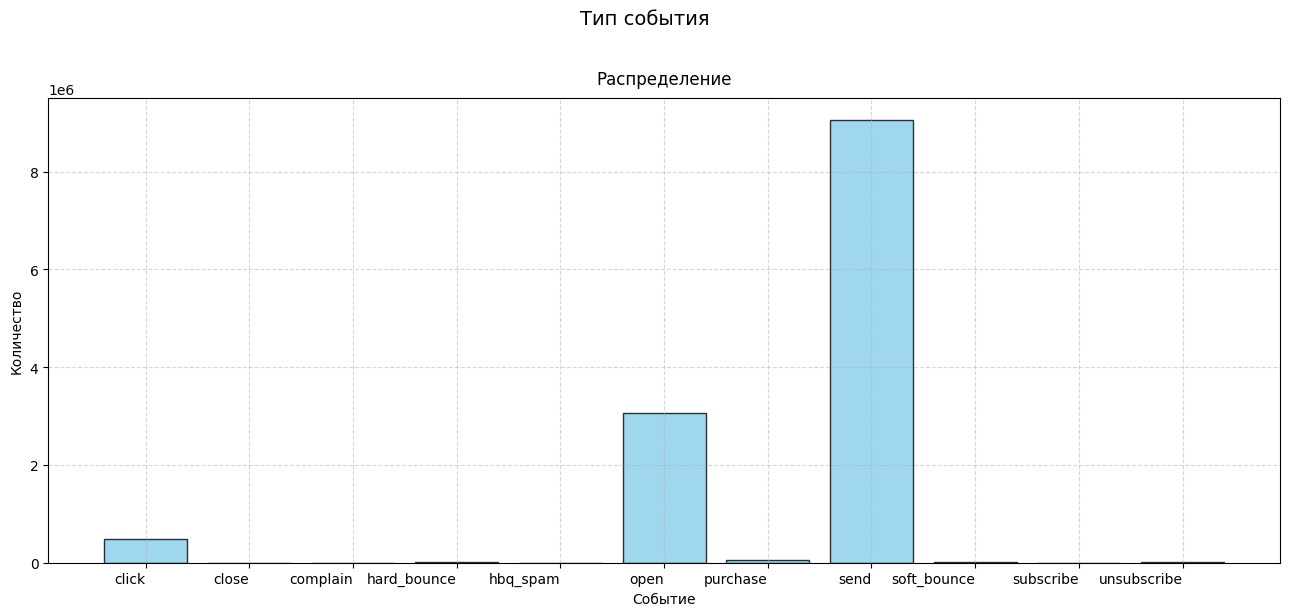

count     12691188
unique          11
top           send
freq       9058174
Name: event, dtype: object

In [442]:
# выведем график распределения
plot_data_analysis(app_messages['event'],
                   title = 'Тип события',
                   x_label = 'Событие',
                   y_label = 'Количество',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

In [443]:
# посмотрим количество значений
app_messages['event'].value_counts()

event
send           9058174
open           3052481
click           483326
purchase         62593
hard_bounce      19763
soft_bounce      10582
unsubscribe       2833
hbq_spam           823
complain           527
subscribe           85
close                1
Name: count, dtype: int64

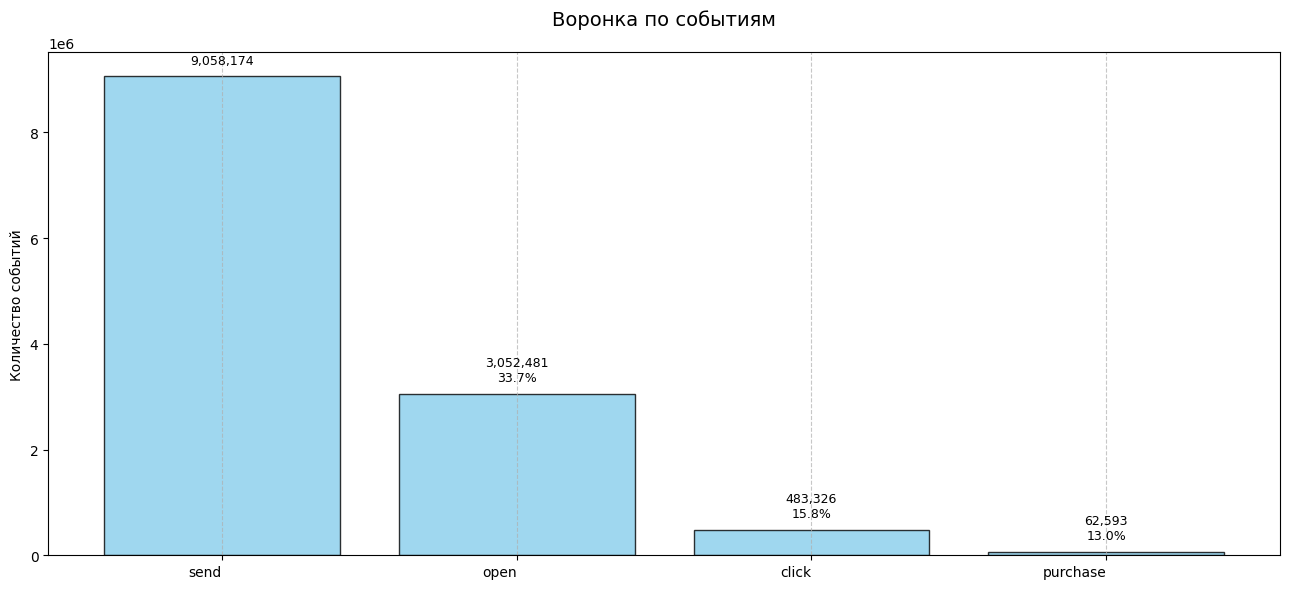

Статистика воронки:
send                       9,058,174: (100.0%)
open                       3,052,481: (33.7% | 33.7%)
click                        483,326: (15.8% | 5.3%)
purchase                      62,593: (13.0% | 0.7%)
Общая конверсия: 0.69%
Потери: 8,995,581 событий


In [444]:
# построим маркетинговую воронку по событиям
plot_funnel(
    app_messages,
    'event',
    ['send', 'open', 'click', 'purchase'],
    title = 'Воронка по событиям',
    orientation = 'horizontal'
)

**Промежуточный вывод**: на основе имеющейся информации о событиях, можно оценить общую конверсию -- $\sim0.71\%$. При этом из общего количества сообщений $34.1\%$ были открыты, $16.1%$ затем прокликаны и $13\%$ пользователей совершили покупку.

#### Признак ```channel```

**Комментарий**: рассмотрим подробнее признак ```channel``` -- канал рассылки.

In [445]:
# посмотрим уникальные значения в столбце channel
app_messages['channel'].unique()

array(['email', 'mobile_push'], dtype=object)

**Комментарий**: видим два уникальных типа рассылки в ```channel```:
- `email` - рассылка по электронной почте;
- `mobile_push` - рассылка через push-уведомления. 

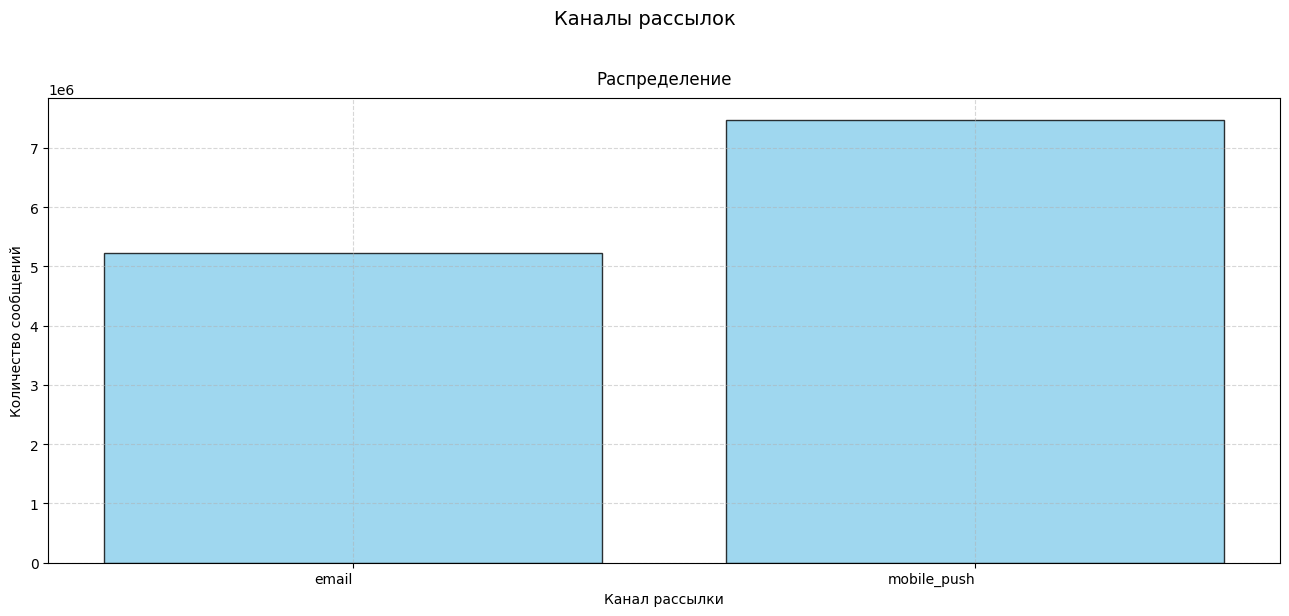

count        12691188
unique              2
top       mobile_push
freq          7470472
Name: channel, dtype: object

In [446]:
# выведем график распределения
plot_data_analysis(app_messages['channel'],
                   title = 'Каналы рассылок',
                   x_label = 'Канал рассылки',
                   y_label = 'Количество сообщений',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

In [447]:
# посмотрим количество значений
app_messages['channel'].value_counts()

channel
mobile_push    7470472
email          5220716
Name: count, dtype: int64

**Промежуточный вывод**: рассылки чаще осуществлялись через ```push``` уведомления. 

#### Промежуточный вывод

По результатам исследовательского анализа данных:
- В данных содержится **2709** уникальных ```id``` рекламных кампаний/рассылок;
- В данных содержится **53329** уникальных клиентов;
- В данных содержится $\sim$**9** млн. уникальных разосланных сообщений;
- На основе имеющейся информации о событиях, можно оценить общую конверсию -- $\sim0.71\%$. При этом из общего количества сообщений $34.1\%$ были открыты, $16.1%$ затем прокликаны и $13\%$ пользователей совершили покупку;
- Рассылки чаще осуществлялись через ```push``` уведомления;
- В данных содержится **53329** уникальных клиентов.

### Таблица ```app_target```

**Комментарий**: исследуем таблицу ```app_target``` -- целевой признак -- совершит ли клиент покупку в течение следующих 90 дней.

#### Признак ```client_id```

**Комментарий**: рассмотрим подробнее признак ```client_id``` -- идентификатор клиента.

In [448]:
# посмотрим количество уникальных значений
print(f'Уникальных клиентов: {app_target['client_id'].nunique()}')

Уникальных клиентов: 49849


**Промежуточный вывод**: в данных содержится **49849** уникальных клиентов (количество совпадает с ```app_purchase```).

#### Признак ```target```

**Комментарий**: рассмотрим подробнее признак ```target``` -- целевой признак.

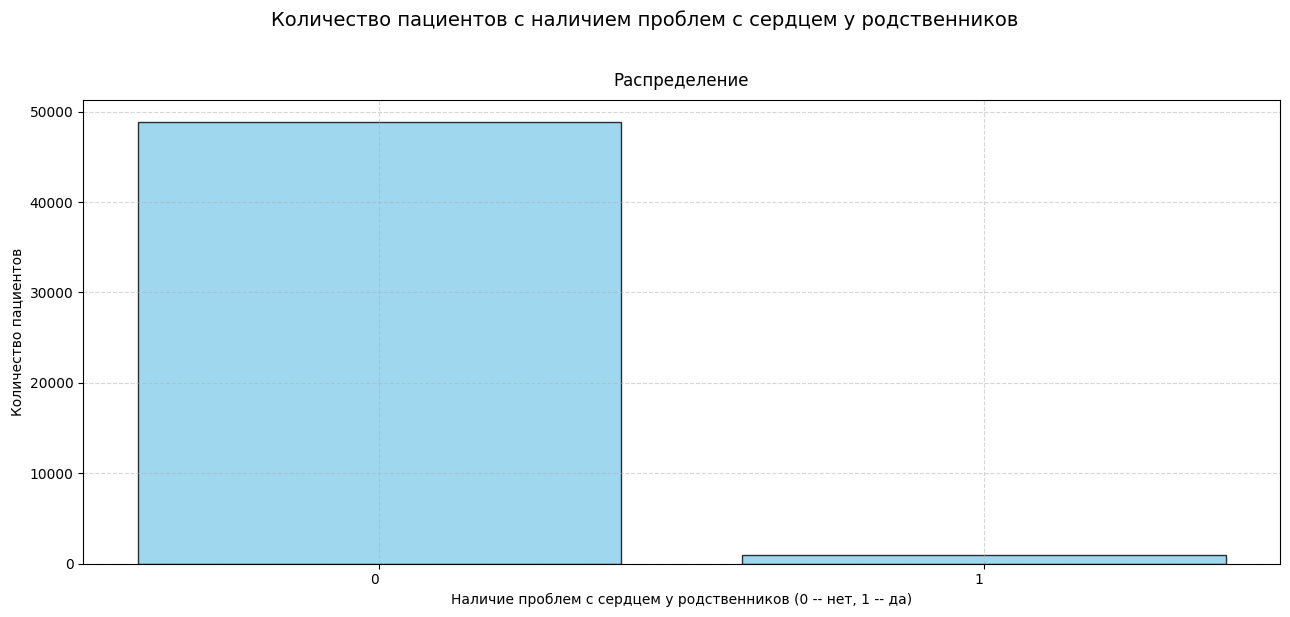

count    49849.000000
mean         0.019278
std          0.137503
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: target, dtype: float64

In [449]:
# выведем график распределения
plot_data_analysis(app_target['target'],
                   title = 'Количество пациентов с наличием проблем с сердцем у родственников',
                   x_label = 'Наличие проблем с сердцем у родственников (0 -- нет, 1 -- да)',
                   y_label = 'Количество пациентов',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

In [450]:
# посмотрим количество значений
app_target['target'].value_counts()

target
0    48888
1      961
Name: count, dtype: int64

**Промежуточный вывод**: в целевом признаке наблюдается сильнейший дисбаланс, необходимо учитывать при обучении моделей.

#### Промежуточный вывод

По результатам исследовательского анализа данных:
- В данных содержится **49849** уникальных клиентов (количество совпадает с ```app_purchase```).
- В целевом признаке наблюдается сильнейший дисбаланс, необходимо учитывать при обучении моделей.

### Объединение данных и создание признаков

**Комментарий**: 

В рамках данных о покупках предлагается создать следующие признаки:

- Суммарное количество потраченных денег
- Суммарное количество купленных товаров
- Количество дней из всего периода, когда совершались покупки
- Дата первой покупки
- Дата последней покупки
- Суммарные значения категорий-маркеров для каждого пользователя
- recency, lifespan
- Самую популярная ключевая категория для каждого пользователя
- Самая популярная конечная категории для каждого пользователя

В качестве отправной даты выберем максимальное значение даты покупки в ```app_purchases```.

In [451]:
last_date = app_purchases['date'].max()

In [452]:
app_purchases['revenue'] = app_purchases['quantity'] * app_purchases['price']

In [453]:
app_purchases.head()

,client_id,quantity,price,date,message_id,leaf_category,marker_category,is_marker_4,is_marker_2,is_marker_667,is_marker_678,is_marker_1786,is_marker_1795,is_marker_550,is_marker_710,is_marker_957,is_marker_636,is_marker_560,is_marker_608,is_marker_681,is_marker_1582,is_marker_1006,is_marker_561,is_marker_555,is_marker_572,is_marker_842,is_marker_1691,is_marker_628,is_marker_551,is_marker_676,is_marker_793,is_marker_637,is_marker_848,is_marker_577,is_marker_602,is_marker_1367,is_marker_1583,is_marker_1080,is_marker_1637,is_marker_1007,is_marker_448,is_marker_1831,is_marker_724,is_marker_1829,is_marker_727,is_marker_1687,is_marker_675,is_marker_1806,is_marker_1052,is_marker_563,is_marker_719,is_marker_601,is_marker_936,is_marker_1778,is_marker_552,is_marker_1360,is_marker_581,is_marker_930,is_marker_582,is_marker_691,is_marker_631,is_marker_564,is_marker_954,is_marker_1705,is_marker_1275,is_marker_573,is_marker_971,is_marker_1420,is_marker_913,is_marker_713,is_marker_824,is_marker_1088,is_marker_593,is_marker_1732,is_marker_1002,is_marker_1004,is_marker_592,is_marker_969,is_marker_1309,is_marker_1851,is_marker_1350,is_marker_1327,is_marker_638,is_marker_571,is_marker_1591,is_marker_594,is_marker_639,is_marker_1279,is_marker_553,is_marker_570,is_marker_508,is_marker_836,is_marker_1343,is_marker_712,is_marker_1304,is_marker_614,is_marker_835,is_marker_611,is_marker_1421,is_marker_761,is_marker_702,is_marker_700,is_marker_575,is_marker_692,is_marker_574,is_marker_1328,is_marker_705,is_marker_927,is_marker_1353,is_marker_857,is_marker_967,is_marker_966,is_marker_1342,is_marker_1326,is_marker_576,is_marker_606,is_marker_1281,is_marker_706,is_marker_755,is_marker_1426,is_marker_1010,is_marker_1773,is_marker_1352,is_marker_668,is_marker_1306,is_marker_569,is_marker_1635,is_marker_666,is_marker_557,is_marker_1685,is_marker_1659,is_marker_1094,is_marker_846,is_marker_1783,is_marker_891,is_marker_894,is_marker_1220,is_marker_634,is_marker_562,is_marker_958,is_marker_1009,is_marker_1681,is_marker_1765,is_marker_1796,is_marker_1665,is_marker_1774,is_marker_1777,is_marker_1682,is_marker_843,is_marker_1200,is_marker_665,is_marker_1418,is_marker_607,is_marker_699,is_marker_1805,is_marker_1707,is_marker_1363,is_marker_612,is_marker_1012,is_marker_664,is_marker_905,is_marker_1699,is_marker_1283,is_marker_965,is_marker_1359,is_marker_1701,is_marker_1702,is_marker_1700,is_marker_735,is_marker_670,is_marker_1399,is_marker_734,is_marker_1,is_marker_1767,is_marker_558,is_marker_844,is_marker_620,is_marker_841,is_marker_1378,is_marker_669,is_marker_1734,is_marker_1335,is_marker_1338,is_marker_1686,is_marker_1766,is_marker_1308,is_marker_1636,is_marker_1697,is_marker_1639,is_marker_1214,is_marker_1715,is_marker_1771,is_marker_1782,is_marker_1670,is_marker_1769,is_marker_1344,is_marker_1014,is_marker_732,is_marker_887,is_marker_5519,is_marker_1673,is_marker_1668,is_marker_792,is_marker_671,is_marker_941,is_marker_591,is_marker_1334,is_marker_595,is_marker_1277,is_marker_1419,is_marker_1684,is_marker_1729,is_marker_914,is_marker_915,is_marker_1588,is_marker_554,is_marker_1728,is_marker_1294,is_marker_1710,is_marker_1366,is_marker_1839,is_marker_1314,is_marker_1807,is_marker_1689,is_marker_854,is_marker_1008,is_marker_1429,is_marker_1076,is_marker_1075,is_marker_845,is_marker_1368,is_marker_1764,is_marker_1703,is_marker_1345,is_marker_1361,is_marker_1633,is_marker_1307,is_marker_1337,is_marker_1100,is_marker_1631,is_marker_1284,is_marker_1365,is_marker_1675,is_marker_1838,is_marker_1310,is_marker_883,is_marker_1850,is_marker_1688,is_marker_1128,is_marker_1104,is_marker_1005,is_marker_559,is_marker_765,is_marker_1020,is_marker_1339,is_marker_1016,is_marker_1810,is_marker_718,is_marker_1221,is_marker_1735,is_marker_632,is_marker_1678,is_marker_708,is_marker_1638,is_marker_769,is_marker_1664,is_marker_850,is_marker_1351,is_marker_1706,is_marker_1726,is_marker_1722,is_marker_1733,is_marker_1078,is_marker_1055,is_marker_1219,is_marker_1224,is_marker_1672,is_ma

**Комментарий**: теперь создадим агрегированные признаки по покупкам для каждого клиента.

In [454]:
purchase_features = app_purchases.groupby('client_id').agg(
    purchase_days=('date', 'nunique'),
    total_revenue=('revenue', 'sum'),
    total_quantity=('quantity', 'sum'),
    first_purchase_date=('date', 'min'),
    last_purchase_date=('date', 'max'),
    total_marker_1=('is_marker_1', 'sum'),
    total_marker_2=('is_marker_2', 'sum'),
    total_marker_3=('is_marker_3', 'sum'),
    total_marker_4=('is_marker_4', 'sum'),
    total_marker_5=('is_marker_5', 'sum')
).reset_index()

purchase_features['recency_days'] = (last_date - purchase_features['last_purchase_date']).dt.days
purchase_features['lifespan_days'] = (purchase_features['last_purchase_date'] - purchase_features['first_purchase_date']).dt.days + 1

popular_leaf_categories = app_purchases.groupby('client_id')['leaf_category'].apply(
    lambda x: x.value_counts().index[0] if len(x) > 0 else 0
)

popular_marker_categories = app_purchases.groupby('client_id')['marker_category'].apply(
    lambda x: x.value_counts().index[0] if len(x) > 0 else 0
)

purchase_features['most_popular_leaf_category'] = purchase_features['client_id'].map(popular_leaf_categories)
purchase_features['most_popular_marker_category'] = purchase_features['client_id'].map(popular_marker_categories)

In [455]:
# кол-во покупок за последние 30 дней  
last_30_days = app_purchases[
    (pd.to_datetime(app_purchases['date']) >= last_date - pd.Timedelta(days=30)) & 
    (pd.to_datetime(app_purchases['date']) <= last_date)
].groupby('client_id').size().reset_index(name='purchases_last_30d')

# кол-во покупок за последние 60 дней
last_60_days = app_purchases[
    (pd.to_datetime(app_purchases['date']) >= last_date - pd.Timedelta(days=60)) & 
    (pd.to_datetime(app_purchases['date']) <= last_date)
].groupby('client_id').size().reset_index(name='purchases_last_60d')

# кол-во покупок за последние 90 дней
last_90_days = app_purchases[
    (pd.to_datetime(app_purchases['date']) >= last_date - pd.Timedelta(days=90)) & 
    (pd.to_datetime(app_purchases['date']) <= last_date)
].groupby('client_id').size().reset_index(name='purchases_last_90d')

# объединяем все с purchase_features
purchase_features = purchase_features.merge(last_30_days, on='client_id', how='left') 
purchase_features = purchase_features.merge(last_60_days, on='client_id', how='left')
purchase_features = purchase_features.merge(last_90_days, on='client_id', how='left')

# заполняем NaN нулями
purchase_features[['purchases_last_30d', 'purchases_last_60d', 'purchases_last_90d']] = purchase_features[
    ['purchases_last_30d', 'purchases_last_60d', 'purchases_last_90d']
].fillna(0)

In [456]:
purchase_features.head()

,client_id,purchase_days,total_revenue,total_quantity,first_purchase_date,last_purchase_date,total_marker_1,total_marker_2,total_marker_3,total_marker_4,total_marker_5,recency_days,lifespan_days,most_popular_leaf_category,most_popular_marker_category,purchases_last_30d,purchases_last_60d,purchases_last_90d
0,1515915625468060902,1,4795.0,5,2022-05-27,2022-05-27,0,0,0,5,0,630,1,458,4,0.0,0.0,0.0
1,1515915625468061003,1,14135.0,6,2023-01-04,2023-01-04,0,0,0,6,0,408,1,615,4,0.0,0.0,0.0
2,1515915625468061099,1,299.0,1,2022-05-17,2022-05-17,0,0,0,1,0,640,1,424,4,0.0,0.0,0.0
3,1515915625468061100,1,1049.0,1,2024-02-10,2024-02-10,0,0,0,1,0,6,1,5717,4,1.0,1.0,1.0
4,1515915625468061170,3,14102.0,8,2023-03-26,2023-06-17,0,1,0,6,0,244,84,420,4,0.0,0.0,0.0


In [457]:
app_messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


**Комментарий**:
- Количество уникальных кампаний
- Количество уникальных сообщений
- Канал сообщения
- Конверсия каждого пользователя

NameError: name 'campaign_features' is not defined

In [458]:
channel_pivot = app_messages.groupby(['client_id', 'channel']).size().unstack(fill_value=0)
channel_pivot.head()

channel,email,mobile_push
client_id,,
1515915625468060902,177,0
1515915625468061003,165,0
1515915625468061099,182,94
1515915625468061100,0,428
1515915625468061170,202,91


In [497]:
# Создаем базовый датафрейм с client_id
campaign_features = pd.DataFrame({'client_id': app_messages['client_id'].unique()})

periods = {
    'last_30d': 30,
    'last_60d': 60, 
    'last_90d': 90
}

for period_name, days in periods.items():
    # Фильтруем данные за период
    period_data = app_messages[app_messages['date'] >= last_date - pd.Timedelta(days=days)]
    
    # Группируем по client_id и event, создаем pivot таблицу
    event_counts = period_data.groupby(['client_id', 'event']).size().unstack(fill_value=0)
    
    # Переименовываем колонки с префиксом периода
    event_counts.columns = [f'event_{event}_{period_name}' for event in event_counts.columns]
    
    # Мерджим с основным датафреймом
    campaign_features = campaign_features.merge(
        event_counts.reset_index(), 
        on='client_id', 
        how='left'
    )

# Заполняем пропуски нулями
campaign_features = campaign_features.fillna(0)
campaign_features.head()

,client_id,event_click_last_30d,event_hard_bounce_last_30d,event_hbq_spam_last_30d,event_open_last_30d,event_purchase_last_30d,event_send_last_30d,event_soft_bounce_last_30d,event_subscribe_last_30d,event_unsubscribe_last_30d,event_click_last_60d,event_hard_bounce_last_60d,event_hbq_spam_last_60d,event_open_last_60d,event_purchase_last_60d,event_send_last_60d,event_soft_bounce_last_60d,event_subscribe_last_60d,event_unsubscribe_last_60d,event_click_last_90d,event_hard_bounce_last_90d,event_hbq_spam_last_90d,event_open_last_90d,event_purchase_last_90d,event_send_last_90d,event_soft_bounce_last_90d,event_subscribe_last_90d,event_unsubscribe_last_90d
0,1515915625626736623,3.0,0.0,0.0,5.0,0.0,31.0,0.0,0.0,0.0,3.0,0.0,0.0,15.0,0.0,63.0,0.0,0.0,0.0,4.0,0.0,0.0,31.0,0.0,93.0,0.0,0.0,0.0
1,1515915625490086521,8.0,0.0,0.0,30.0,0.0,30.0,0.0,0.0,0.0,31.0,0.0,0.0,54.0,2.0,54.0,0.0,0.0,0.0,31.0,0.0,0.0,84.0,2.0,84.0,0.0,0.0,0.0
2,1515915625553578558,0.0,1.0,0.0,17.0,0.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,34.0,0.0,52.0,0.0,0.0,0.0,0.0,1.0,0.0,59.0,0.0,82.0,0.0,0.0,0.0
3,1515915625471518311,0.0,0.0,0.0,12.0,0.0,19.0,0.0,0.0,0.0,1.0,0.0,0.0,24.0,0.0,35.0,0.0,0.0,0.0,1.0,0.0,0.0,29.0,0.0,42.0,0.0,0.0,0.0
4,1515915625594606468,2.0,0.0,0.0,27.0,0.0,31.0,0.0,0.0,0.0,4.0,0.0,0.0,55.0,0.0,64.0,0.0,0.0,0.0,5.0,0.0,0.0,71.0,0.0,81.0,0.0,0.0,0.0


In [499]:
events_pivot = app_messages.groupby(['client_id', 'event']).size().unstack(fill_value=0)
events_pivot.columns = [f'event_{col}' for col in events_pivot.columns]
events_pivot.head()

,event_click,event_close,event_complain,event_hard_bounce,event_hbq_spam,event_open,event_purchase,event_send,event_soft_bounce,event_subscribe,event_unsubscribe
client_id,,,,,,,,,,,
1515915625468060902,10,0,0,0,0,35,5,126,0,0,1
1515915625468061003,5,0,0,0,0,5,1,154,0,0,0
1515915625468061099,8,0,0,2,0,51,0,215,0,0,0
1515915625468061100,1,0,0,1,0,157,1,267,1,0,0
1515915625468061170,16,0,0,0,0,31,3,243,0,0,0


In [500]:
# CTR (клики / отправки)
events_pivot['ctr'] = np.where(
    events_pivot['event_send'] > 0,
    events_pivot['event_click'] / events_pivot['event_send'],
    0
)

# Open Rate (открытия / отправки)
events_pivot['open_rate'] = np.where(
    events_pivot['event_send'] > 0,
    events_pivot['event_open'] / events_pivot['event_send'],
    0
)

# Conversion Rate (покупки / клики)
events_pivot['conversion_rate'] = np.where(
    events_pivot['event_click'] > 0,
    events_pivot['event_purchase'] / events_pivot['event_click'],
    0
)

# Click-to-Open Rate (клики / открытия)
events_pivot['cto_rate'] = np.where(
    events_pivot['event_open'] > 0,
    events_pivot['event_click'] / events_pivot['event_open'],
    0
)

# Unsubscribe Rate (отписки / отправки)
events_pivot['unsubscribe_rate'] = np.where(
    events_pivot['event_send'] > 0,
    events_pivot['event_unsubscribe'] / events_pivot['event_send'],
    0
)

# Bounce Rate (все отбои / отправки)
events_pivot['bounce_rate'] = np.where(
    events_pivot['event_send'] > 0,
    (events_pivot['event_hard_bounce'] + events_pivot['event_soft_bounce']) / events_pivot['event_send'],
    0
)

In [501]:
events_features = events_pivot.merge(
        channel_pivot,
        on='client_id',
        how='left'
).merge(
        campaign_features,
        on='client_id',
        how='left'
)

In [502]:
events_features.head()

,client_id,event_click,event_close,event_complain,event_hard_bounce,event_hbq_spam,event_open,event_purchase,event_send,event_soft_bounce,event_subscribe,event_unsubscribe,ctr,open_rate,conversion_rate,cto_rate,unsubscribe_rate,bounce_rate,email,mobile_push,event_click_last_30d,event_hard_bounce_last_30d,event_hbq_spam_last_30d,event_open_last_30d,event_purchase_last_30d,event_send_last_30d,event_soft_bounce_last_30d,event_subscribe_last_30d,event_unsubscribe_last_30d,event_click_last_60d,event_hard_bounce_last_60d,event_hbq_spam_last_60d,event_open_last_60d,event_purchase_last_60d,event_send_last_60d,event_soft_bounce_last_60d,event_subscribe_last_60d,event_unsubscribe_last_60d,event_click_last_90d,event_hard_bounce_last_90d,event_hbq_spam_last_90d,event_open_last_90d,event_purchase_last_90d,event_send_last_90d,event_soft_bounce_last_90d,event_subscribe_last_90d,event_unsubscribe_last_90d
0,1515915625468060902,10,0,0,0,0,35,5,126,0,0,1,0.079365,0.277778,0.5000,0.285714,0.007937,0.000000,177,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,5.0,0.0,11.0,0.0,0.0,1.0,2.0,0.0,0.0,6.0,0.0,19.0,0.0,0.0,1.0
1,1515915625468061003,5,0,0,0,0,5,1,154,0,0,0,0.032468,0.032468,0.2000,1.000000,0.000000,0.000000,165,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,16.0,0.0,0.0,0.0
2,1515915625468061099,8,0,0,2,0,51,0,215,0,0,0,0.037209,0.237209,0.0000,0.156863,0.000000,0.009302,182,94,0.0,0.0,0.0,1.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,0.0,0.0,0.0
3,1515915625468061100,1,0,0,1,0,157,1,267,1,0,0,0.003745,0.588015,1.0000,0.006369,0.000000,0.007491,0,428,1.0,0.0,0.0,20.0,1.0,23.0,1.0,0.0,0.0,1.0,0.0,0.0,39.0,1.0,44.0,1.0,0.0,0.0,1.0,0.0,0.0,60.0,1.0,68.0,1.0,0.0,0.0
4,1515915625468061170,16,0,0,0,0,31,3,243,0,0,0,0.065844,0.127572,0.1875,0.516129,0.000000,0.000000,202,91,0.0,0.0,0.0,0.0,0.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,108.0,0.0,0.0,0.0


In [503]:
df_master = purchase_features.merge(
    events_features,
    on='client_id',
    how='left'
).merge(
    app_target,
    on='client_id',
    how='left'
)

In [504]:
df_master.head()

,client_id,purchase_days,total_revenue,total_quantity,first_purchase_date,last_purchase_date,total_marker_1,total_marker_2,total_marker_3,total_marker_4,total_marker_5,recency_days,lifespan_days,most_popular_leaf_category,most_popular_marker_category,purchases_last_30d,purchases_last_60d,purchases_last_90d,event_click,event_close,event_complain,event_hard_bounce,event_hbq_spam,event_open,event_purchase,event_send,event_soft_bounce,event_subscribe,event_unsubscribe,ctr,open_rate,conversion_rate,cto_rate,unsubscribe_rate,bounce_rate,email,mobile_push,event_click_last_30d,event_hard_bounce_last_30d,event_hbq_spam_last_30d,event_open_last_30d,event_purchase_last_30d,event_send_last_30d,event_soft_bounce_last_30d,event_subscribe_last_30d,event_unsubscribe_last_30d,event_click_last_60d,event_hard_bounce_last_60d,event_hbq_spam_last_60d,event_open_last_60d,event_purchase_last_60d,event_send_last_60d,event_soft_bounce_last_60d,event_subscribe_last_60d,event_unsubscribe_last_60d,event_click_last_90d,event_hard_bounce_last_90d,event_hbq_spam_last_90d,event_open_last_90d,event_purchase_last_90d,event_send_last_90d,event_soft_bounce_last_90d,event_subscribe_last_90d,event_unsubscribe_last_90d,target
0,1515915625468060902,1,4795.0,5,2022-05-27,2022-05-27,0,0,0,5,0,630,1,458,4,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,35.0,5.0,126.0,0.0,0.0,1.0,0.079365,0.277778,0.5000,0.285714,0.007937,0.000000,177.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,5.0,0.0,11.0,0.0,0.0,1.0,2.0,0.0,0.0,6.0,0.0,19.0,0.0,0.0,1.0,0
1,1515915625468061003,1,14135.0,6,2023-01-04,2023-01-04,0,0,0,6,0,408,1,615,4,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,1.0,154.0,0.0,0.0,0.0,0.032468,0.032468,0.2000,1.000000,0.000000,0.000000,165.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,16.0,0.0,0.0,0.0,1
2,1515915625468061099,1,299.0,1,2022-05-17,2022-05-17,0,0,0,1,0,640,1,424,4,0.0,0.0,0.0,8.0,0.0,0.0,2.0,0.0,51.0,0.0,215.0,0.0,0.0,0.0,0.037209,0.237209,0.0000,0.156863,0.000000,0.009302,182.0,94.0,0.0,0.0,0.0,1.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,0.0,0.0,0.0,0
3,1515915625468061100,1,1049.0,1,2024-02-10,2024-02-10,0,0,0,1,0,6,1,5717,4,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,157.0,1.0,267.0,1.0,0.0,0.0,0.003745,0.588015,1.0000,0.006369,0.000000,0.007491,0.0,428.0,1.0,0.0,0.0,20.0,1.0,23.0,1.0,0.0,0.0,1.0,0.0,0.0,39.0,1.0,44.0,1.0,0.0,0.0,1.0,0.0,0.0,60.0,1.0,68.0,1.0,0.0,0.0,0
4,1515915625468061170,3,14102.0,8,2023-03-26,2023-06-17,0,1,0,6,0,244,84,420,4,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,31.0,3.0,243.0,0.0,0.0,0.0,0.065844,0.127572,0.1875,0.516129,0.000000,0.000000,202.0,91.0,0.0,0.0,0.0,0.0,0.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,108.0,0.0,0.0,0.0,0


In [505]:
df_master.shape

(49849, 65)

## <u>Корреляционный анализ</u>

In [506]:
df_master.drop(columns=['client_id'], inplace=True)

In [507]:
# сформируем список столбцов с непрерывными признаками
interval_columns = df_master.select_dtypes(include='number').columns.tolist()
interval_columns = [c for c in interval_columns if c not in ['client_id', 'target']]

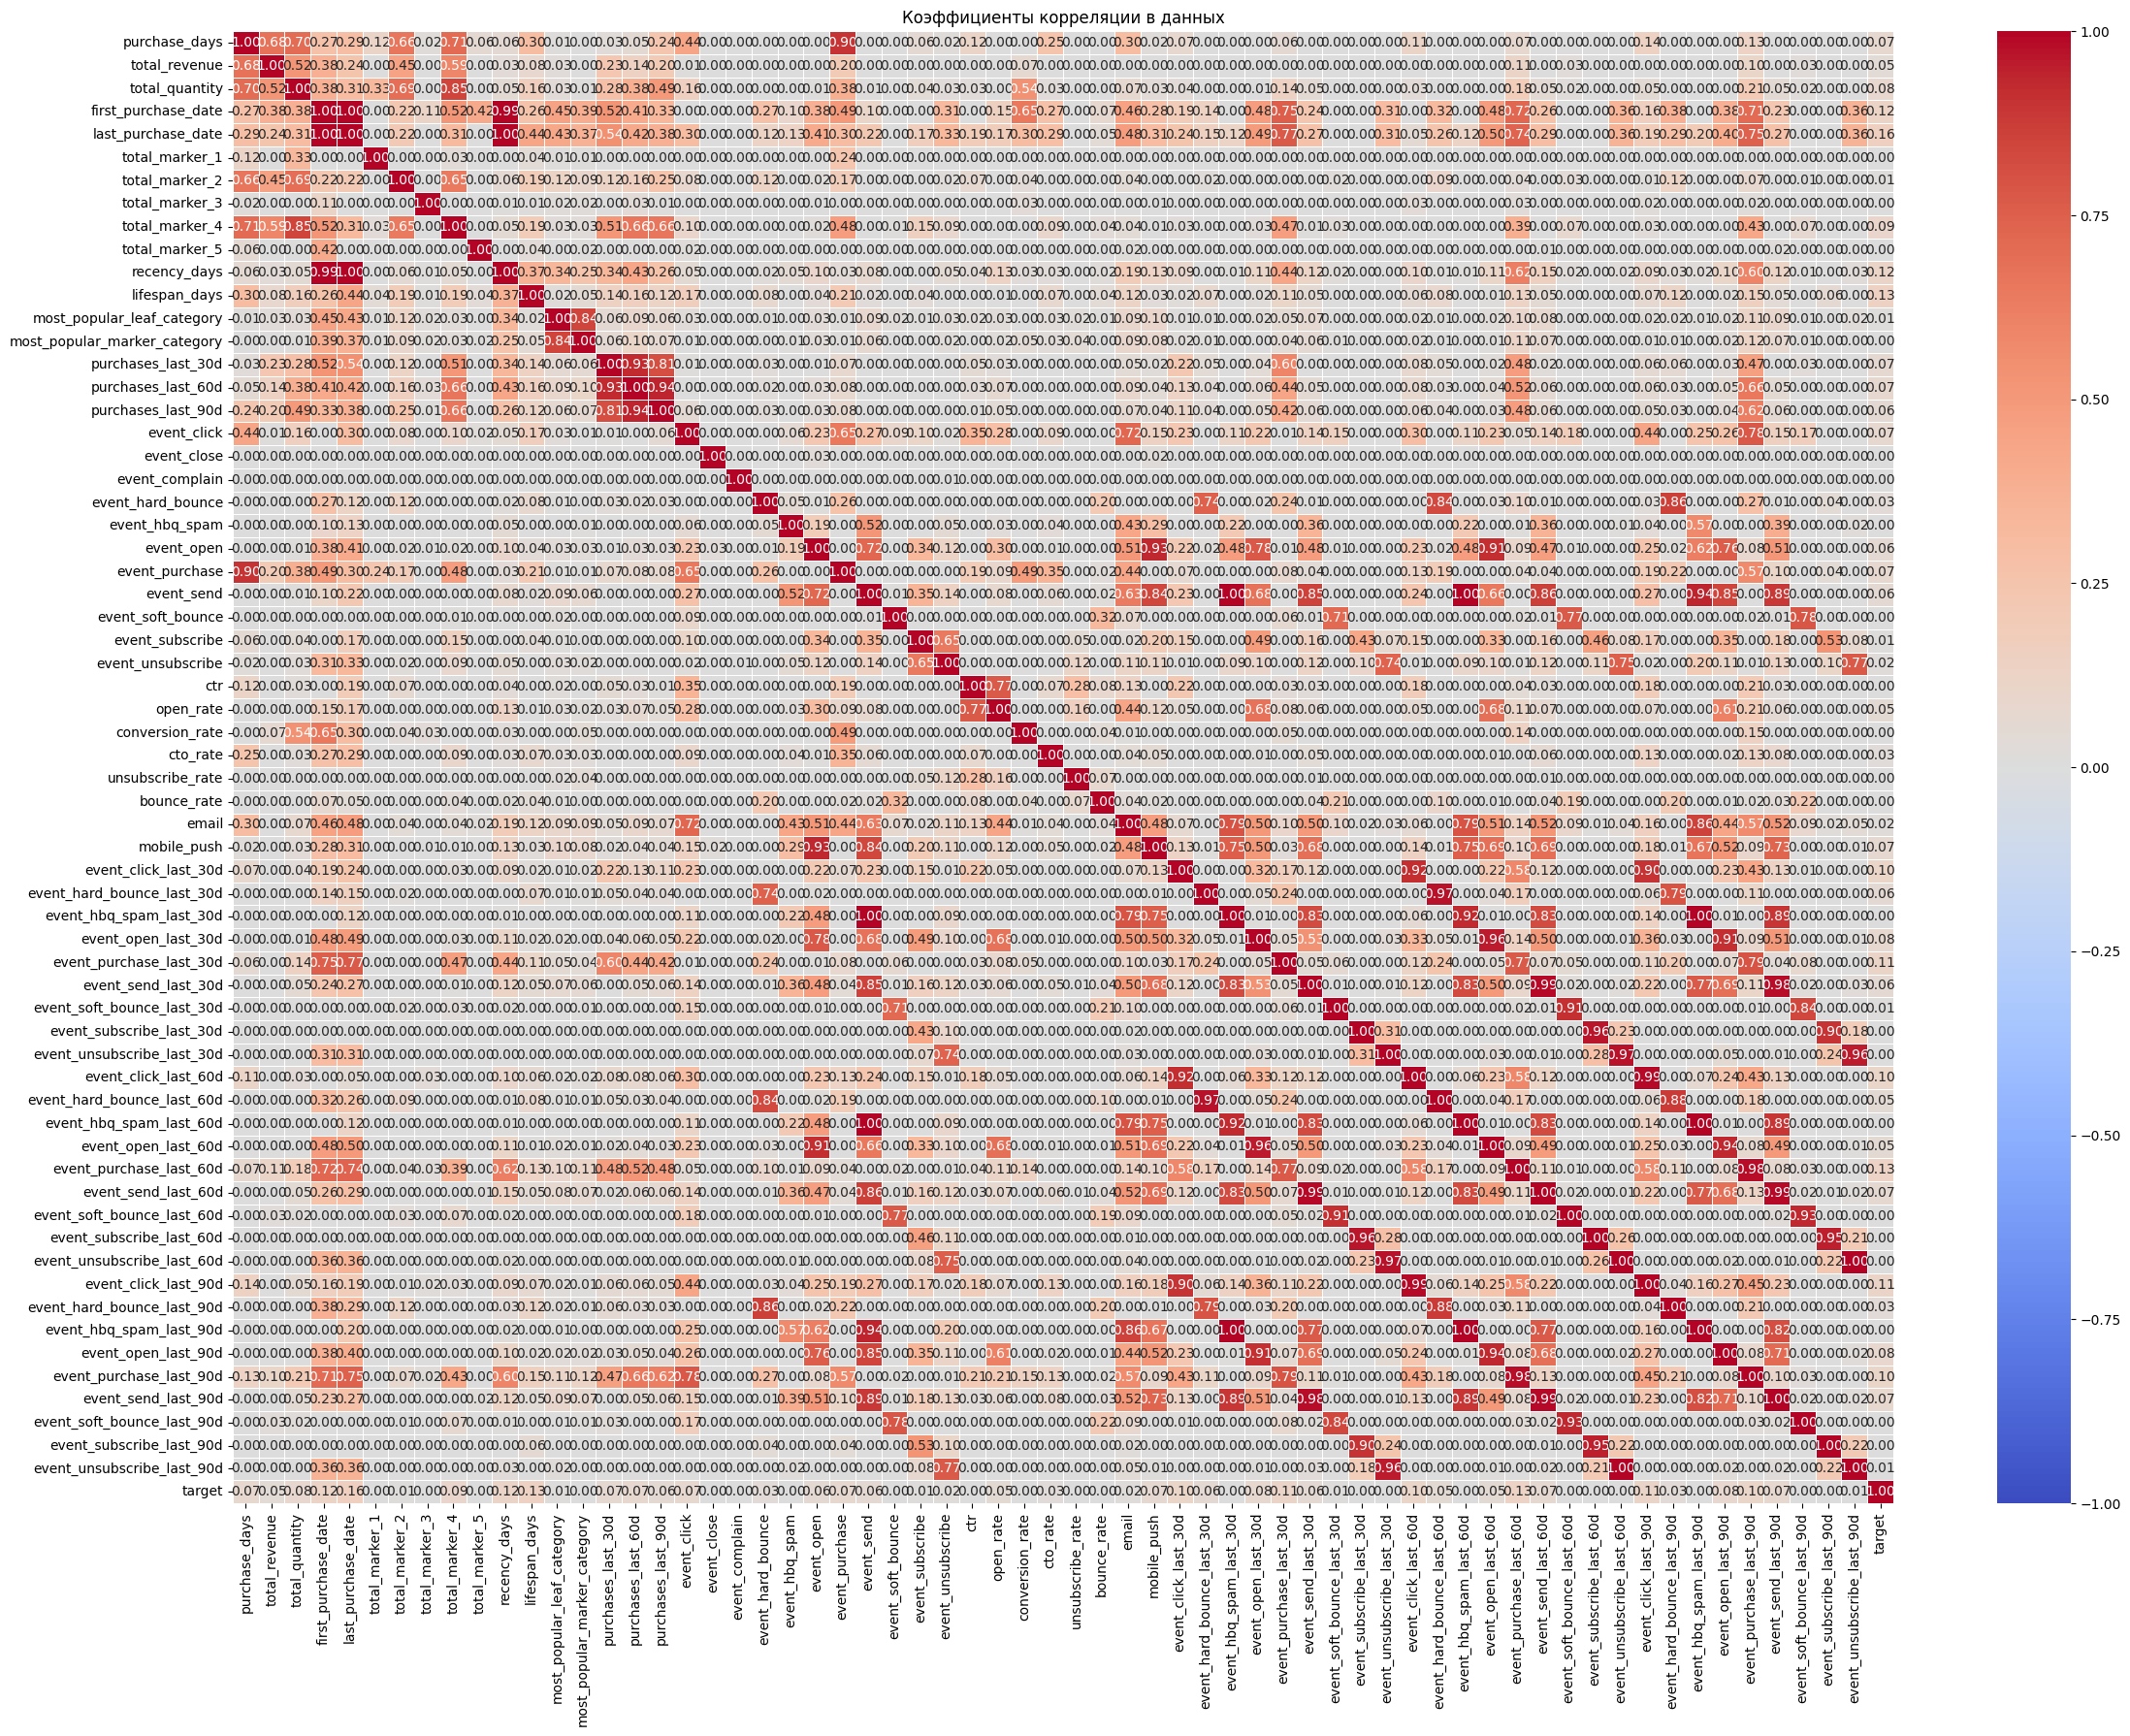

,purchase_days,total_revenue,total_quantity,first_purchase_date,last_purchase_date,total_marker_1,total_marker_2,total_marker_3,total_marker_4,total_marker_5,recency_days,lifespan_days,most_popular_leaf_category,most_popular_marker_category,purchases_last_30d,purchases_last_60d,purchases_last_90d,event_click,event_close,event_complain,event_hard_bounce,event_hbq_spam,event_open,event_purchase,event_send,event_soft_bounce,event_subscribe,event_unsubscribe,ctr,open_rate,conversion_rate,cto_rate,unsubscribe_rate,bounce_rate,email,mobile_push,event_click_last_30d,event_hard_bounce_last_30d,event_hbq_spam_last_30d,event_open_last_30d,event_purchase_last_30d,event_send_last_30d,event_soft_bounce_last_30d,event_subscribe_last_30d,event_unsubscribe_last_30d,event_click_last_60d,event_hard_bounce_last_60d,event_hbq_spam_last_60d,event_open_last_60d,event_purchase_last_60d,event_send_last_60d,event_soft_bounce_last_60d,event_subscribe_last_60d,event_unsubscribe_last_60d,event_click_last_90d,event_hard_bounce_last_90d,event_hbq_spam_last_90d,event_open_last_90d,event_purchase_last_90d,event_send_last_90d,event_soft_bounce_last_90d,event_subscribe_last_90d,event_unsubscribe_last_90d,target
purchase_days,1.000000,0.675188,0.696644,0.271341,0.294692,0.117165,0.661194,0.021049,0.710766,0.057934,0.060857,0.304590,0.010512,0.000000,0.031001,0.051037,0.235415,0.442602,0.000000,0.000000,0.000000,0.000000,0.000000,0.901987,0.000000,0.000000,0.056559,0.022243,0.115711,0.000000,0.000000,0.254576,0.000000,0.000000,0.297292,0.020089,0.070770,0.000000,0.000000,0.000000,0.061094,0.000000,0.000000,0.000000,0.000000,0.112020,0.000000,0.000000,0.000000,0.070642,0.000000,0.000000,0.000000,0.000000,0.135257,0.000000,0.000000,0.000000,0.131330,0.000000,0.000000,0.000000,0.000000,0.074335
total_revenue,0.675188,1.000000,0.519381,0.377459,0.244327,0.000000,0.451727,0.000000,0.592053,0.000000,0.032740,0.081924,0.029751,0.000000,0.231609,0.144986,0.196385,0.011139,0.000000,0.000000,0.000000,0.000000,0.000000,0.201802,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069932,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.109725,0.000000,0.025942,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.102227,0.000000,0.025944,0.000000,0.000000,0.045234
total_quantity,0.696644,0.519381,1.000000,0.377177,0.311517,0.327158,0.693093,0.000000,0.849910,0.000000,0.048617,0.164194,0.034019,0.007941,0.280114,0.384372,0.492719,0.163305,0.000000,0.000000,0.000000,0.000000,0.014242,0.383615,0.011447,0.000000,0.044935,0.026331,0.028207,0.000000,0.536056,0.028346,0.000000,0.000000,0.071539,0.032584,0.038317,0.000000,0.000000,0.005795,0.135160,0.048583,0.000000,0.000000,0.000000,0.032565,0.000000,0.000000,0.000000,0.183838,0.049594,0.017440,0.000000,0.000000,0.047765,0.000000,0.000000,0.000000,0.206560,0.050651,0.017452,0.000000,0.000000,0.081293
first_purchase_date,0.271341,0.377459,0.377177,1.000000,0.999979,0.000000,0.218991,0.112450,0.520659,0.421349,0.993901,0.260314,0.446981,0.393859,0.524468,0.408255,0.328473,0.000000,0.000000,0.000000,0.267630,0.095674,0.375872,0.492309,0.102886,0.000000,0.000000,0.313696,0.000000,0.154634,0.654832,0.265807,0.000000,0.074206,0.457564,0.280548,0.189957,0.141669,0.000000,0.476972,0.750797,0.240985,0.000000,0.000000,0.308220,0.000000,0.316304,0.000000,0.483535,0.719155,0.263329,0.000000,0.000000,0.357337,0.160465,0.381696,0.000000,0.382249,0.706446,0.229646,0.000000,0.000000,0.364763,0.123334
last_purchase_date,0.294692,0.244327,0.311517,0.999979,1.000000,0.000000,0.216298,0.000000,0.314215,0.000000,1.000000,0.443278,0.427669,0.369718,0.544340,0.421505,0.378789,0.304607,0.000000,0.000000,0.118573,0.129359,0.411282,0.304154,0.219991,0.000000,0.171138,0.333167,0.192074,0.174401,0.302570,0.288235,0.000000,0.046576,0.482365,0.308066,0.244350,0.153421,0.117343,0.491176,0.768729,0.269603,0.000000,0.000000,0.311816,0.047670,0.2

In [508]:
# рассчитаем корреляцию и построим матрицу коэффициентов корреляции и тепловую карту
corr_matrix = plot_corr_heatmap(df_master,
                                title = 'Коэффициенты корреляции в данных',
                                columns = interval_columns)
display(corr_matrix)

In [509]:
# проведем беглый анализ корреляционной матрицы
corr_res = corr_analysis(corr_matrix, target_feature='target', min_abs_corr=1e-8)

In [510]:
# выведем результаты анализа корреляционной матрицы
display(corr_res)

,Признак,Корреляция,Сила связи,Направление
0,last_purchase_date,0.164,Слабая,положительная
1,lifespan_days,0.134,Слабая,положительная
2,event_purchase_last_60d,0.132,Слабая,положительная
3,first_purchase_date,0.123,Слабая,положительная
4,recency_days,0.116,Слабая,положительная
5,event_purchase_last_30d,0.112,Слабая,положительная
6,event_click_last_90d,0.112,Слабая,положительная
7,event_click_last_60d,0.104,Слабая,положительная
8,event_purchase_last_90d,0.104,Слабая,положительная
9,event_click_last_30d,0.102,Слабая,положительная


## <u>Обучение модели</u>

**Комментарий**: перейдем теперь к подготовки данных и обучению модели.

Для CV будем использовать `roc_auc`, а на валидационной выборке полную метрику (следим за ```precision```, ```recall```, ```f1/f2```).

В целом не ясно, какую задачу будет решать модель, поэтому также оставим возможность настройки порога между ```precision``` и ```recall``` и будем искать исходя из баланса и того, и другого (построим кривую `precision-recall`). Возможность изменить порог в дальнейшем заложим в функционал приложения.

Для чего это нужно: при максимизации `recall` мы будет чаще находить пациентов, которые действительно обладают риском, однако вместе с ними чаще будем предсказывать риск здоровым пациентам. В этом случае мы можем создать нагрузку на систему здравоохранения, отправляя здоровых на доп. исследования. В ином случае, при низком `recall` сиутация становится с точностью да наоборот.

Поэтому еще раз следует подчеркнуть -- т.к. не сформулирована окончательная задача, где и как будет использоваться модель, то внедряем возможность менять порог.

### Подготовка данных

In [511]:
X = df_master.drop('target', axis=1)
y = df_master['target']
target_feature = 'target'

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=y  # сохраняем пропорции целевого признака
)

print(f"Размер обучающей выборки: {len(X_train)}")
print(f"Размер валидационной выборки: {len(X_test)}\n")
print(f"Пропроция целевого признака в обучающей выборке:\n{y_train.value_counts(normalize=True)}\n")
print(f"Пропроция целевого признака в валидационной выборке:\n{y_test.value_counts(normalize=True)}")

Размер обучающей выборки: 37386
Размер валидационной выборки: 12463

Пропроция целевого признака в обучающей выборке:
target
0    0.980715
1    0.019285
Name: proportion, dtype: float64

Пропроция целевого признака в валидационной выборке:
target
0    0.980743
1    0.019257
Name: proportion, dtype: float64


In [512]:
# формируем списки признаков
num_columns = interval_columns

In [513]:
# количественные признаки
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# препроцессор
data_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_columns)
    ])

In [514]:
# составим список моделей и наборов гиперпараметров
scalers = {
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
}
models = [
    {
        'model': DummyClassifier(),
        'params': {
            'model__strategy': ['stratified', 'most_frequent', 'prior', 'uniform'],
            **scalers
        },
        'name': 'Dummy'
    },
    {
        'model': LogisticRegression(random_state=RANDOM_STATE),
        'params': {
            'model__C': [0.1, 1.0, 10.0],
            'model__penalty': ['l1', 'l2', 'elasticnet'],
            'model__solver': ['liblinear', 'saga'],
            'model__max_iter': [1000],
            'model__class_weight': ['balanced'],
            **scalers
        },
        'name': 'LogisticRegression'
    },
    {
        'model': DecisionTreeClassifier(random_state=RANDOM_STATE),
        'params': {
            'model__max_depth': [3, 5, 7, 10, 12, 14, 16, 18],
            'model__min_samples_split': [2, 5, 10, 12, 14, 16, 18],
            'model__min_samples_leaf': [1, 2, 4, 6, 8],
            'model__criterion': ['gini', 'entropy'],
            'model__class_weight': ['balanced'],
            **scalers
        },
        'name': 'DecisionTreeClassifier'
    },
    {
        'model': GradientBoostingClassifier(random_state=RANDOM_STATE),
        'params': {
            'model__n_estimators': [50, 100, 200, 500, 1000],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 4, 5, 6],
            'model__subsample': [0.4, 0.6, 0.8, 1.0],
            **scalers
        },
        'name': 'GradientBoostingClassifier'
    },
    {
        'model': RandomForestClassifier(random_state=RANDOM_STATE),
        'params': {
            'model__n_estimators': [100, 200, 300, 500, 1000],
            'model__max_depth': [5, 10, 15],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4],
            'model__class_weight': ['balanced'],
            **scalers
        },
        'name': 'RandomForestClassifier'
    },
    {
        'model': XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1),
        'params': {
            'model__iterations': [300, 500, 800, 1200],
            'model__depth': [4, 6, 8, 10],
            'model__learning_rate': [0.03, 0.05, 0.1],
            'model__l2_leaf_reg': [3, 5, 7, 9],
            'model__scale_pos_weight': [20, 40, 51, 70, 100, 150],
            'model__border_count': [128, 254],
            'model__random_strength': [0, 1, 2],
            'model__bagging_temperature': [0, 0.5, 1],
            **scalers
        },
        'name': 'XGBClassifier'
    },
    {
    'model': CatBoostClassifier(random_state=RANDOM_STATE, verbose=False),
    'params': {
        'model__n_estimators': [300, 500, 800, 1200],
        'model__max_depth': [3, 5, 7, 9],
        'model__learning_rate': [0.01, 0.03, 0.05, 0.1],
        'model__l2_leaf_reg': [1, 3, 5, 7],
        'model__border_count': [32, 64, 128],
        'model__scale_pos_weight': [20, 40, 51, 70, 100, 150]
    },
    'name': 'CatBoostClassifier'
}
]

In [515]:
# в цикле выполним подбор параметров, замеряем время обучения, предсказания и подборов параметров
results = []
for mdl in models:
    results.append(evaluate_model(mdl['model'], 
                                  mdl['params'], 
                                  mdl['name'],
                                  X_train,
                                  y_train,
                                  data_preprocessor,
                                  data_preprocessor,
                                  refit_metric='roc_auc',
                                  random_state=RANDOM_STATE,
                                  cv=5,
                                  n_iter=10))

Модель: Dummy
Лучшие параметры: {'preprocessor__num__scaler': RobustScaler(), 'model__strategy': 'stratified'}
Время подбора параметров: 2.835 с.
Время обучения лучшей модели: 0.579 с.
Время предсказания лучшей модели: 0.144 с.
Accuracy на кросс-валидации: 0.9619
Precision на кросс-валидации: 0.0227
Recall на кросс-валидации: 0.0236
ROC-AUC на кросс-валидации: 0.5004
F1-score на кросс-валидации: 0.0231
F2-score на кросс-валидации: 0.0234
Average Precision на кросс-валидации: 0.0195

Модель: LogisticRegression
Лучшие параметры: {'preprocessor__num__scaler': MinMaxScaler(), 'model__solver': 'saga', 'model__penalty': 'l1', 'model__max_iter': 1000, 'model__class_weight': 'balanced', 'model__C': 1.0}
Время подбора параметров: 38.640 с.
Время обучения лучшей модели: 18.001 с.
Время предсказания лучшей модели: 0.045 с.
Accuracy на кросс-валидации: 0.7791
Precision на кросс-валидации: 0.0518
Recall на кросс-валидации: 0.6048
ROC-AUC на кросс-валидации: 0.7591
F1-score на кросс-валидации: 0.095

In [517]:
# сформируем DataFrame из итоговых результатов и выведем таблицу
results_df = pd.DataFrame(results).copy()
if not results_df.empty:
    # выведем таблицу с результатами по всем моделям
    print("Итоговые результаты:")
    display(results_df[['model_name', 
                    'accuracy_cv', 
                    'precision_cv',
                    'recall_cv',
                    'roc_auc_cv',
                    'average_precision_cv',
                    'f1_cv',
                    'f2_cv',
                    'params_time',
                    'train_time',
                    'predict_time']].sort_values(['roc_auc_cv'],
                                                 ascending=False).reset_index(drop=True))

    # лучшая модель по recall
    best_model_metrics = results_df.sort_values(['roc_auc_cv'],
                                                ascending=False).iloc[0]

    # выводим результат
    print(f"Лучшая модель: {best_model_metrics['model_name']}") 
    print(f"Average Precision на кросс-валидации = {best_model_metrics['average_precision_cv']:.4f}")
    print(f"Recall на кросс-валидации = {best_model_metrics['recall_cv']:.4f}")
    print(f"ROC-AUC на кросс-валидации = {best_model_metrics['roc_auc_cv']:.4f}")
    print(f"F1-score на кросс-валидации = {best_model_metrics['f1_cv']:.4f}")
    print(f"F2-score на кросс-валидации = {best_model_metrics['f2_cv']:.4f}")
    print(f"Accuracy на кросс-валидации = {best_model_metrics['accuracy_cv']:.4f}")
    print(f"Precision на кросс-валидации = {best_model_metrics['precision_cv']:.4f}")
    print(f"train_time = {best_model_metrics['train_time']:.3f} с.")
    print(f"predict_time = {best_model_metrics['predict_time']:.3f} c.")

    best_final_model = best_model_metrics['best_model']
else:
    print("Ошибка в получении модели!")

Итоговые результаты:


,model_name,accuracy_cv,precision_cv,recall_cv,roc_auc_cv,average_precision_cv,f1_cv,f2_cv,params_time,train_time,predict_time
0,CatBoostClassifier,0.767908,0.051947,0.639425,0.767161,0.087292,0.096084,0.196011,120.660948,25.554303,0.129825
1,GradientBoostingClassifier,0.980581,0.500000,0.016628,0.764804,0.096371,0.031616,0.020517,155.044696,62.983054,0.134943
2,RandomForestClassifier,0.807708,0.058687,0.595029,0.764155,0.075410,0.106813,0.210305,32.993546,7.385136,0.384552
3,LogisticRegression,0.779142,0.051829,0.604761,0.759075,0.091988,0.095470,0.192960,38.640146,18.000848,0.045180
4,XGBClassifier,0.948109,0.105168,0.224732,0.752585,0.074375,0.143199,0.182985,7.856922,2.096029,0.106891
5,DecisionTreeClassifier,0.755926,0.046408,0.585297,0.694161,0.055338,0.085904,0.175653,3.198826,0.836233,0.134038
6,Dummy,0.961911,0.022702,0.023554,0.500389,0.019452,0.023093,0.023361,2.835258,0.579058,0.143960


Лучшая модель: CatBoostClassifier
Average Precision на кросс-валидации = 0.0873
Recall на кросс-валидации = 0.6394
ROC-AUC на кросс-валидации = 0.7672
F1-score на кросс-валидации = 0.0961
F2-score на кросс-валидации = 0.1960
Accuracy на кросс-валидации = 0.7679
Precision на кросс-валидации = 0.0519
train_time = 25.554 с.
predict_time = 0.130 c.


### Промежуточный вывод

Была сформирована тестовая и валидационная выброки с ratio 0.25.
После этого выполнялся подбор лучшей модели и её гиперпараметров.

По результатам лучшей моделью оказался классификатор `GradientBoostingClassifier` с метриками:
- Recall на кросс-валидации = 0.4565
- ROC-AUC на кросс-валидации = 0.7552
- F1-score на кросс-валидации = 0.5197
- F2-score на кросс-валидации = 0.4798
- Accuracy на кросс-валидации = 0.7176
- Precision на кросс-валидации = 0.6041

## <u>Тестирование модели</u>

**Комментарий**: выполним тестирование лучшей найденной модели на валидационной выборке. 

In [518]:
# выведем модель
print(best_final_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['purchase_days',
                                                   'total_revenue',
                                                   'total_quantity',
                                                   'total_marker_1',
                                                   'total_marker_2',
                                                   'total_marker_3',
                                                   'total_marker_4',
                                                   'total_marker_5',
               

Метрики на тестовой выборке для финальной модели CatBoostClassifier:
Accuracy: 0.7633
Precision: 0.0498
Recall: 0.6250
F1-score: 0.0923
F2-score: 0.1889
ROC-AUC: 0.7665
Average Precision: 0.0849

Матрица ошибок:
[[9363 2860]
 [  90  150]]


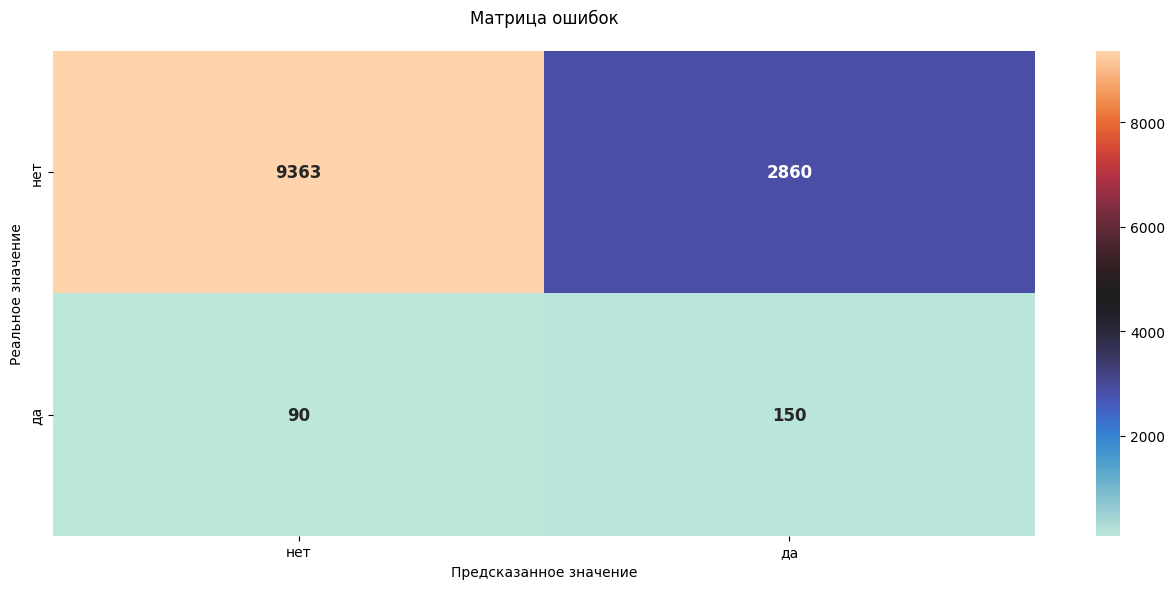

Интерпретация:
  Правильно предсказано 'нет' (True Negative): 9363
  Ложно предсказано 'да' (False Positive): 2860
  Ложно предсказано 'нет' (False Negative): 90
  Правильно предсказано 'да' (True Positive): 150


In [519]:
y_pred = best_final_model.predict(X_test)
# вероятности для положительного класса
y_pred_proba = best_final_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2)
roc_auc = roc_auc_score(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

print(f"Метрики на тестовой выборке для финальной модели {best_model_metrics['model_name']}:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"F2-score: {f2:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Average Precision: {average_precision:.4f}")

# выведем матрицу ошибок
print("\nМатрица ошибок:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plot_confusion_matrix(cm)

**Комментарий**: на валидационных данных метрика получилась даже лучше, чем на CV:
- Accuracy: 0.7740
- Precision: 0.7179
- Recall: 0.5350
- F1-score: 0.6131
- F2-score: 0.5638
- ROC-AUC: 0.8112
- Average Precision: 0.7302

Рассмотрим теперь кривую `precision-recall` и подберем оптимальный порог по умолчанию.

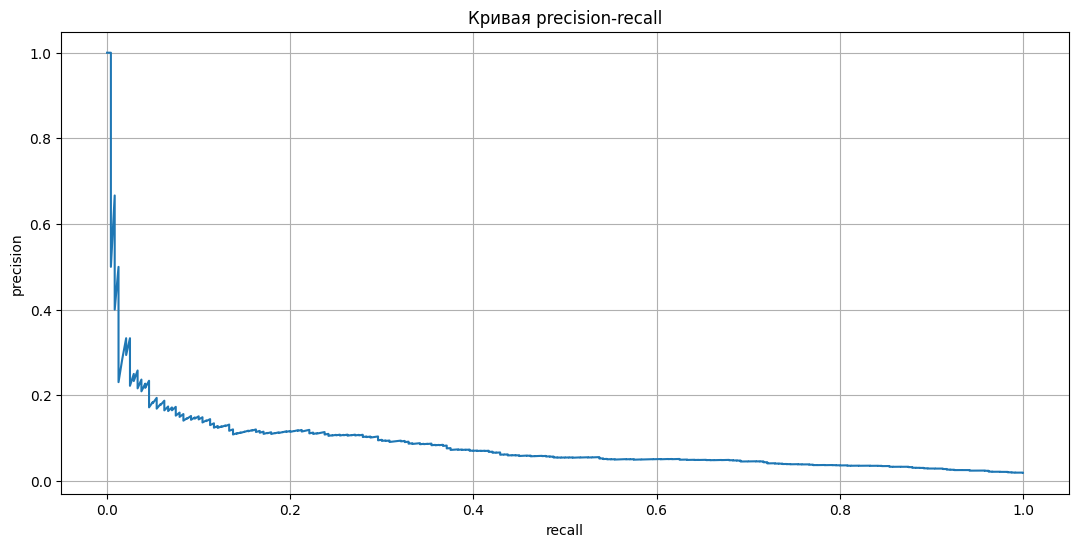

Recall 0.1: threshold=0.846, precision=0.145, f1=0.118
Recall 0.2: threshold=0.790, precision=0.115, f1=0.146
Recall 0.3: threshold=0.737, precision=0.094, f1=0.143
Recall 0.4: threshold=0.667, precision=0.070, f1=0.120
Recall 0.5: threshold=0.579, precision=0.055, f1=0.098
Recall 0.6: threshold=0.517, precision=0.051, f1=0.094
Recall 0.7: threshold=0.449, precision=0.046, f1=0.086
Recall 0.75: threshold=0.401, precision=0.039, f1=0.074
Recall 0.8: threshold=0.370, precision=0.036, f1=0.069
Recall 0.85: threshold=0.354, precision=0.035, f1=0.067
Recall 0.9: threshold=0.315, precision=0.029, f1=0.056
Recall 1.0: threshold=0.016, precision=0.019, f1=0.038


In [520]:
if hasattr(best_final_model.named_steps['model'], 'predict_proba'):
    y_pred_proba = best_final_model.predict_proba(X_test)[:, 1]
else:
    # для SVC используем decision_function
    y_pred_proba = best_final_model.decision_function(X_test)
    # нормализуем к [0, 1]
    y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())

# строим PR curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# строим график
plt.figure(figsize=(13, 6))
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Кривая precision-recall')
plt.grid(True)
plt.show()

# смотрим варианты порогов
results_r = []
for target_recall in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1.0]:
    # находим ближайший порог
    idx = np.argmin(np.abs(recall[:-1] - target_recall))
    threshold = thresholds[idx]
    
    # применяем порог
    y_pred_custom = (y_pred_proba > threshold).astype(int)
    
    # cчитаем метрики
    prec = precision_score(y_test, y_pred_custom)
    rec = recall_score(y_test, y_pred_custom)
    f1 = f1_score(y_test, y_pred_custom)
    
    results_r.append({
        'target_recall': target_recall,
        'threshold': threshold,
        'precision': prec,
        'recall': rec,
        'f1': f1
    })
    
    print(f"Recall {target_recall}: threshold={threshold:.3f}, precision={prec:.3f}, f1={f1:.3f}")


In [521]:
#  оптимальный порог
optimal_threshold = 0.779

# вероятности на тестовой выборке
y_pred_proba_test = best_final_model.predict_proba(X_test)[:, 1]

# используем порог
y_pred_custom = (y_pred_proba_test > optimal_threshold).astype(int)


print(f"Accuracy: {accuracy_score(y_test, y_pred_custom):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_custom):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_custom):.4f}")
print(f"F1: {f1_score(y_test, y_pred_custom):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_test):.4f}")

print("\nМатрица ошибок:")
print(confusion_matrix(y_test, y_pred_custom))

Accuracy: 0.9512
Precision: 0.1118
Recall: 0.2208
F1: 0.1485
ROC-AUC: 0.7665

Матрица ошибок:
[[11802   421]
 [  187    53]]


**Промежуточный вывод**: на валидационных данных метрика получилась даже лучше, чем на CV. 
Был подобран оптимальный порог классификации $0.25$, который дает метрику:
- Accuracy: 0.7484
- Precision: 0.6211
- Recall: 0.6369
- F1: 0.6289
- ROC-AUC: 0.8112

## <u>Анализ фажности признаков</u>

**Комментарий**: выполним теперь анализ важности признаков

In [522]:
# получаем имена 
feature_names = best_final_model.named_steps['preprocessor'].get_feature_names_out()
    
# подготавливаем данные
X_sample = best_final_model.named_steps['preprocessor'].transform(X_test)
  
model = best_final_model.named_steps['model']
model_name = best_model_metrics['model_name']

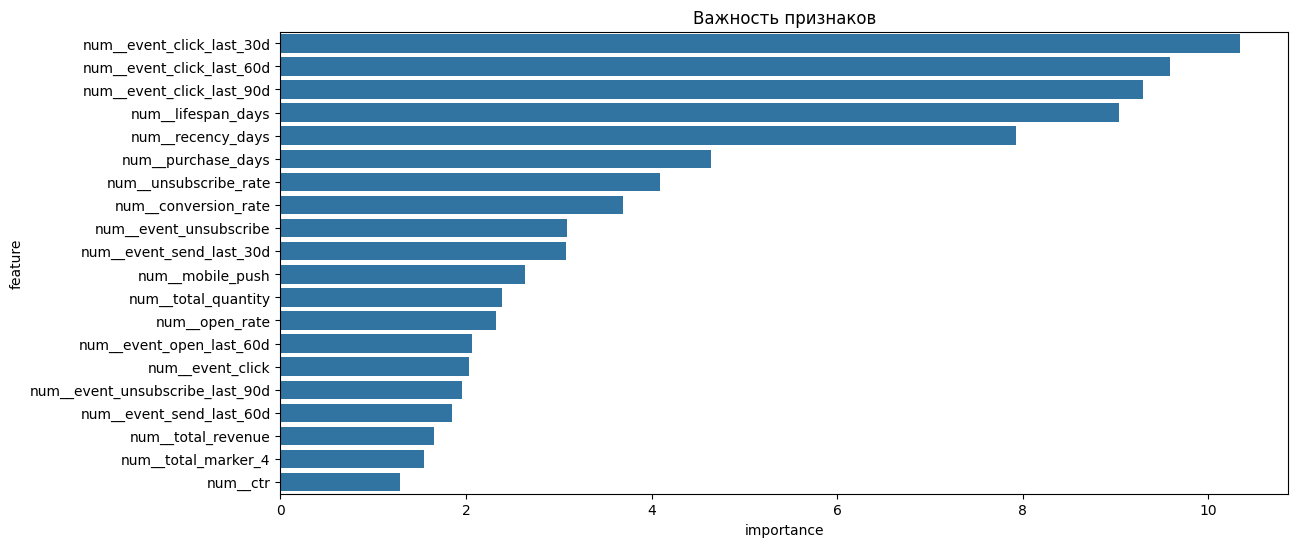

Топ-20 важных признаков:
                            feature  importance
34        num__event_click_last_30d   10.341683
43        num__event_click_last_60d    9.589923
52        num__event_click_last_90d    9.299325
9                num__lifespan_days    9.034262
8                 num__recency_days    7.923251
0                num__purchase_days    4.637705
30            num__unsubscribe_rate    4.089657
28             num__conversion_rate    3.697668
25           num__event_unsubscribe    3.093496
39         num__event_send_last_30d    3.075519
33                 num__mobile_push    2.637034
2               num__total_quantity    2.387706
27                   num__open_rate    2.325404
46         num__event_open_last_60d    2.068423
15                 num__event_click    2.033665
60  num__event_unsubscribe_last_90d    1.960074
48         num__event_send_last_60d    1.844584
1                num__total_revenue    1.659849
6               num__total_marker_4    1.542814
26             

In [523]:
# feature importance (стандартная)
if hasattr(model, 'feature_importances_'):
    importance = model.feature_importances_
        
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
        
    plt.figure(figsize=(13, 6))
    sns.barplot(x='importance', y='feature', data=importance_df.head(20))
    plt.title(f'Важность признаков')
    plt.show()
        
    print("Топ-20 важных признаков:")
    print(importance_df.head(20))
else:
    print(f"Модель {model_name} не имеет атрибута feature_importances_")


SHAP анализ для CatBoostClassifier:


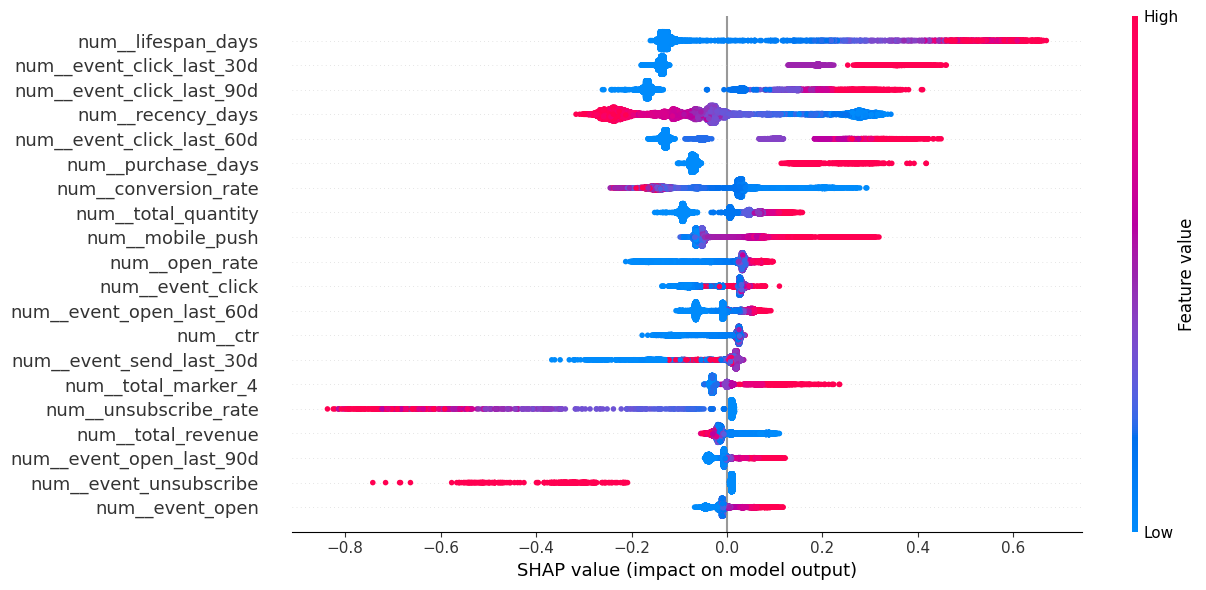

In [524]:
print(f"\nSHAP анализ для {best_model_metrics['model_name']}:")
try:
    if any(tree_model in model_name for tree_model in 
           ['RandomForest', 'DecisionTree', 'XGB', 'LGBM', 'CatBoost', 'GradientBoosting']):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_sample)  
    elif 'LogisticRegression' in model_name:
        explainer = shap.LinearExplainer(model, X_sample)
        shap_values = explainer.shap_values(X_sample)
    else:
        explainer = shap.Explainer(model, X_sample)
        shap_values = explainer(X_sample)
    
    # summary plot
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
    plt.gcf().set_size_inches(13, 6)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Ошибка при SHAP анализе: {str(e)}")

In [ ]:
# обрабатываем SHAP значения
if isinstance(shap_values, list):
    if len(shap_values) == 2:
        shap_values_processed = shap_values[1]
    else:
        shap_values_processed = shap_values
else:
    shap_values_processed = shap_values

# вычисляем важность признаков
if len(shap_values_processed.shape) == 2:
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': np.abs(shap_values_processed).mean(axis=0)
    })
else:
    # если другая структура
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': np.abs(shap_values_processed).mean(axis=0)
    })

# сортируем по важности
feature_importance = feature_importance.sort_values('importance', ascending=False)

# выводим топ важных признаков
print("Топ важных признаков (SHAP):")

for i, row in feature_importance.head(50).iterrows():
    print(f"{i+1:2d}. {row['feature']:35} | Важность: {row['importance']:.4f}")


ТОП-20 ВАЖНЕЙШИХ ПРИЗНАКОВ ПО SHAP:
10. num__lifespan_days                  | Важность: 0.1643
35. num__event_click_last_30d           | Важность: 0.1606
53. num__event_click_last_90d           | Важность: 0.1563
 9. num__recency_days                   | Важность: 0.1507
44. num__event_click_last_60d           | Важность: 0.1376
 1. num__purchase_days                  | Важность: 0.0885
29. num__conversion_rate                | Важность: 0.0863
 3. num__total_quantity                 | Важность: 0.0675
34. num__mobile_push                    | Важность: 0.0660
28. num__open_rate                      | Важность: 0.0616
16. num__event_click                    | Важность: 0.0455
47. num__event_open_last_60d            | Важность: 0.0421
27. num__ctr                            | Важность: 0.0411
40. num__event_send_last_30d            | Важность: 0.0343
 7. num__total_marker_4                 | Важность: 0.0308
31. num__unsubscribe_rate               | Важность: 0.0294
 2. num__total_reve

Топ признаков для отбора (после очистки префиксов):
 1. lifespan_days
 2. event_click_last_30d
 3. event_click_last_90d
 4. recency_days
 5. event_click_last_60d
 6. purchase_days
 7. conversion_rate
 8. total_quantity
 9. mobile_push
10. open_rate
11. event_click
12. event_open_last_60d
13. ctr
14. event_send_last_30d
15. total_marker_4
16. unsubscribe_rate
17. total_revenue
18. event_open_last_90d
19. event_unsubscribe
20. event_open
21. event_open_last_30d
22. event_send
23. event_send_last_60d
24. most_popular_leaf_category
25. email
26. cto_rate
27. purchases_last_90d
28. purchases_last_30d
29. event_purchase
30. event_unsubscribe_last_90d

Переобучение CatBoostClassifier на топ-20 признаках...

Метрики на тестовой выборке для модели с топ признаками:
Accuracy: 0.7605
Precision: 0.0490
Recall: 0.6208
F1-score: 0.0908
F2-score: 0.1861
ROC-AUC: 0.7692
Average Precision: 0.0856

Матрица ошибок (топ признаков):
[[9329 2894]
 [  91  149]]


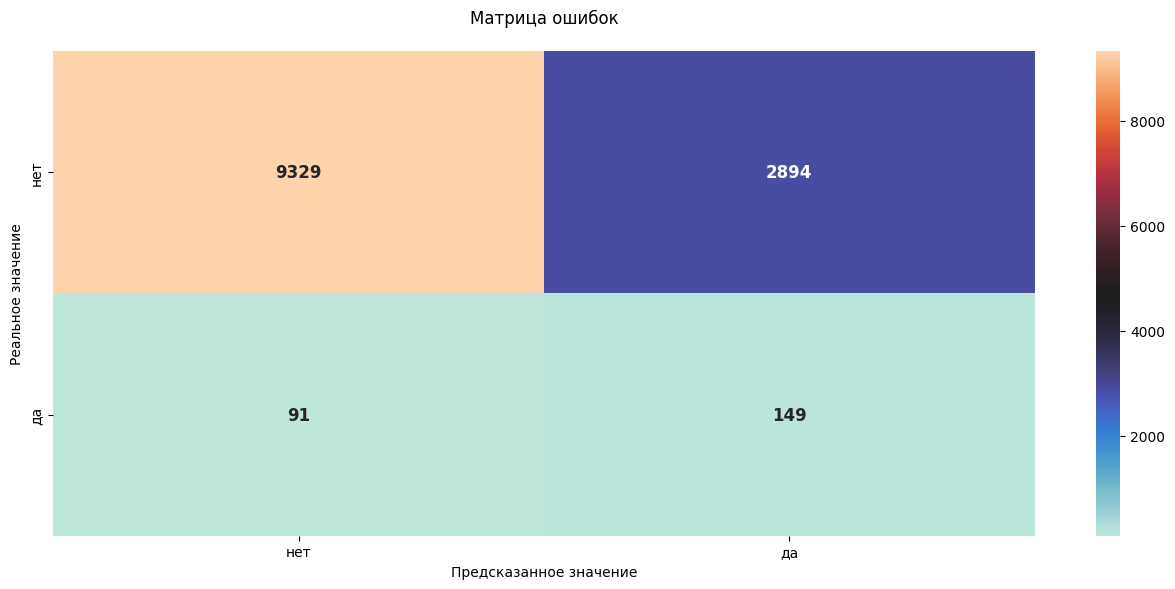

Интерпретация:
  Правильно предсказано 'нет' (True Negative): 9329
  Ложно предсказано 'да' (False Positive): 2894
  Ложно предсказано 'нет' (False Negative): 91
  Правильно предсказано 'да' (True Positive): 149


In [535]:
# Получаем список топ признаков из SHAP анализа
top_features = feature_importance.head(30)['feature'].tolist()

# Убираем префиксы 'num__' и 'cat__' из названий признаков
top_features_clean = [feature.replace('num__', '').replace('cat__', '') for feature in top_features]

print("Топ признаков для отбора (после очистки префиксов):")
for i, feature in enumerate(top_features_clean, 1):
    print(f"{i:2d}. {feature}")

# Получаем классификатор из исходного пайплайна
original_classifier = best_final_model.named_steps['model']

# Создаем новый ColumnTransformer только для выбранных признаков
preprocessor_top = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), top_features_clean)
    ],
    remainder='drop'  # ВАЖНО: отбрасываем все остальные признаки
)

# cоздаем новый пайплайн
model_top = Pipeline([
    ('preprocessor', preprocessor_top),
    ('classifier', type(original_classifier)(**original_classifier.get_params()))
])

print(f"\nПереобучение {best_model_metrics['model_name']} на топ-20 признаках...")

# обучаем на сокращенном наборе признаков
model_top.fit(X_train[top_features_clean], y_train)

# Предсказания на тестовой выборке
y_pred_top = model_top.predict(X_test[top_features_clean])
y_pred_proba_top = model_top.predict_proba(X_test[top_features_clean])[:, 1]

# Дальше твой код с метриками...
accuracy_top = accuracy_score(y_test, y_pred_top)
precision_top = precision_score(y_test, y_pred_top)
recall_top = recall_score(y_test, y_pred_top)
f1_top = f1_score(y_test, y_pred_top)
f2_top = fbeta_score(y_test, y_pred_top, beta=2)
roc_auc_top = roc_auc_score(y_test, y_pred_proba_top)
average_precision_top = average_precision_score(y_test, y_pred_proba_top)

print(f"\nМетрики на тестовой выборке для модели с топ признаками:")
print(f"Accuracy: {accuracy_top:.4f}")
print(f"Precision: {precision_top:.4f}")
print(f"Recall: {recall_top:.4f}")
print(f"F1-score: {f1_top:.4f}")
print(f"F2-score: {f2_top:.4f}")
print(f"ROC-AUC: {roc_auc_top:.4f}")
print(f"Average Precision: {average_precision_top:.4f}")

# Матрица ошибок для модели с топ признаками
print("\nМатрица ошибок (топ признаков):")
cm_top = confusion_matrix(y_test, y_pred_top)
print(cm_top)
plot_confusion_matrix(cm_top)

## <u>Итоговый вывод</u>